# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### EDA

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import keras.backend as K
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from catboost import cv, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from ydata_profiling import ProfileReport
import shap

C:\ana\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\ana\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

очень крутаяч штука , делает eda за тебя. окинул взор на данные при помощи неё . Всё что увидел напишу в выводе блока

сразу приводим к нижнему регистру название колонок

In [5]:
data.columns = data.columns.str.lower()
data

datecrawled  price  vehicletype  registrationyear gearbox  \
0       2016-03-24 11:52:17    480          NaN              1993  manual   
1       2016-03-24 10:58:45  18300        coupe              2011  manual   
2       2016-03-14 12:52:21   9800          suv              2004    auto   
3       2016-03-17 16:54:04   1500        small              2001  manual   
4       2016-03-31 17:25:20   3600        small              2008  manual   
...                     ...    ...          ...               ...     ...   
354364  2016-03-21 09:50:58      0          NaN              2005  manual   
354365  2016-03-14 17:48:27   2200          NaN              2005     NaN   
354366  2016-03-05 19:56:21   1199  convertible              2000    auto   
354367  2016-03-19 18:57:12   9200          bus              1996  manual   
354368  2016-03-20 19:41:08   3400        wagon              2002  manual   

        power        model  kilometer  registrationmonth  fueltype  \
0           0         golf     150000                  0    petrol   
1         190          NaN     125000                  5  gasoline   
2         163        grand     125000                  8  gasoline   
3          75         golf     150000                  6    petrol   
4          69        fabia      90000                  7  gasoline   
...       ...          ...        ...                ...       ...   
354364      0         colt     150000                  7    petrol   
354365      0          NaN      20000                  1       NaN   
354366    101       fortwo     125000                  3    petrol   
354367    102  transporter     150000                  3  gasoline   
354368    100         golf     150000                  6  gasoline   

                 brand repaired          datecreated  numberofpictures  \
0           volkswagen      NaN  2016-03-24 00:00:00                 0   
1                 audi      yes  2016-03-24 00:00:00                 0   
2                 jeep      NaN  2016-03-14 00:00:00                 0   
3           volkswagen       no  2016-03-17 00:00:00                 0   
4                skoda       no  2016-03-31 00:00:00                 0   
...                ...      ...                  ...               ...   
354364      mitsubishi      yes  2016-03-21 00:00:00                 0   
354365  sonstige_autos      NaN  2016-03-14 00:00:00                 0   
354366           smart       no  2016-03-05 00:00:00                 0   
354367      volkswagen       no  2016-03-19 00:00:00                 0   
354368      volkswagen      NaN  2016-03-20 00:00:00                 0   

        postalcode             lastseen  
0            70435  2016-04-07 03:16:57  
1            66954  2016-04-07 01:46:50  
2            90480  2016-04-05 12:47:46  
3            91074  2016-03-17 17:40:17  
4            60437  2016-04-06 10:17:21  
...            ...                  ...  
354364        2694  2016-03-21 10:42:49  
354365       39576  2016-04-06 00:46:52  
354366       26135  2016-03-11 18:17:12  
354367       87439  2016-04-07 07:15:26  
354368       40764  2016-03-24 12:45:21  

[354369 rows x 16 columns]

но это слишком просто , нужно eda и ручками поделать)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
data['postalcode'].value_counts()

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
91801      1
31097      1
82444      1
94359      1
31096      1
Name: postalcode, Length: 8143, dtype: int64

In [8]:
(data['postalcode'].value_counts() > 1).sum()

7996

In [9]:
(data['postalcode'].value_counts() > 100).sum()

935

интересно , есть регионы с супер большим количеством объявлений

In [10]:
data.duplicated().sum()

4

In [11]:
data = data[~data.duplicated()]

4 дубликата , когда-то здесь было)

In [12]:
print(data['datecrawled'].min())
data['datecrawled'].max()

2016-03-05 14:06:22


'2016-04-07 14:36:58'

актуальная стоимость машины не зависит от времени особо , сразу удалим в будущем всё что связано со временем (объясню проще у нас не задача с временными рядами + машина и ночью и днём будет иметь ожинаковую стоимость) + также нюанс временной промежуток примерно месяц , предположим что все анкеты актуальны 

In [13]:
data.describe()

price  registrationyear          power      kilometer  \
count  354365.000000     354365.000000  354365.000000  354365.000000   
mean     4416.679830       2004.234481     110.093816  128211.363989   
std      4514.176349         90.228466     189.851330   37905.083858   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       registrationmonth  numberofpictures     postalcode  
count      354365.000000          354365.0  354365.000000  
mean            5.714650               0.0   50508.503800  
std             3.726432               0.0   25783.100078  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

In [14]:
data['vehicletype'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [15]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [16]:
data.isna().sum().sort_values(ascending = False)

repaired             71154
vehicletype          37490
fueltype             32895
gearbox              19833
model                19705
datecrawled              0
price                    0
registrationyear         0
power                    0
kilometer                0
registrationmonth        0
brand                    0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

вывод eda: есть категореальные типы данных , в будущем будут закодирова при помощи OHE + Target incoding
<br>target пропусков не имеет , но пропуски присутствуют в немаловажных признаках сумарное количество строчек с пропусками +- 25-30%
<br>явные дубликаты присутсвовали в количестве 4 шт , но на данный момент уже удалены
<br>странных значений обнаружено были в столбце price (стоимость 0 картошек , жесть) , также остальные столбцы имеют выбрасы и значения противоречащие логике например (год выпуска модели 2010 , а регистрация в 2006))
<br>данные нуждаются в серьёзной очистке 

### предобработка

строчки с пропусками в модели мы убераем , это очень важный параметр . Строки без модели не имеют смысла . (спойлер имеют , но не так много , мб был прав что удалил). объясню свою позицию. Не бывает машин без марки и модели и я считаю что эти парраметры критически важны для адекватной оценки и работы системы

In [17]:
data = data[~data['model'].isna()]

тип коробки передач можно попробовать восстановить , ровно как и fueltype и VehicleType и вот делема , была машина в ремонте или нет

In [18]:
data['repaired'].value_counts()

no     238852
yes     33708
Name: repaired, dtype: int64

ну похоже на то что битых машин намного меньше , возможно они не указывали этот параметр потому что либо А) не указал из-за того что не хотел тратить время на это и машина не бита Б) захотел обмануть не указал значит не говорил про битость. Но скорее всего небитых машин больше из-за дисбаланса класса. я думаю что стоит попробовать 2 подхода 1) заполнение нулями 2)удаление фичи и посмотрим что даст точность выше (спойлер не попробую)

In [19]:
data['repaired'] = data['repaired'].fillna('no')

In [20]:
data.isna().sum().sort_values(ascending = False)

vehicletype          30662
fueltype             25732
gearbox              15702
datecrawled              0
price                    0
registrationyear         0
power                    0
model                    0
kilometer                0
registrationmonth        0
brand                    0
repaired                 0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [21]:
pivot = data.pivot_table(values = 'repaired',index = ['model','vehicletype','brand'],aggfunc = 'count')
pivot = pivot.reset_index()
pivot

model  vehicletype       brand  repaired
0        100  convertible        audi         1
1        100        coupe        audi         2
2        100        sedan        audi       278
3        100        wagon        audi       109
4        145        coupe  alfa_romeo         2
...      ...          ...         ...       ...
1406  zafira        other        opel        23
1407  zafira        sedan        opel        22
1408  zafira        small        opel        11
1409  zafira          suv        opel         7
1410  zafira        wagon        opel       229

[1411 rows x 4 columns]

а круто одна модель имеет разные типы кузова имеют

In [22]:
pivot_unique = pivot.value_counts('model')[pivot.value_counts('model') == 1]

что я сейчас делаю. Если модель выпускалась только в одном корпусе то мы легко можем восстановить тип корпуса. Для этого сгруппируем по частоте встреч модели , если у модели один тип корпуса , она попадётся всего 1 раз 

In [23]:
%%time
for u in pivot_unique.index:
    data.loc[(data['model']==u) & (data['vehicletype'].isna()),'vehicletype'] = pivot.loc[pivot['model'] == u,'vehicletype'].iloc[0]

CPU times: total: 281 ms
Wall time: 318 ms


In [24]:
data.isna().sum().sort_values(ascending = False)

vehicletype          30600
fueltype             25732
gearbox              15702
datecrawled              0
price                    0
registrationyear         0
power                    0
model                    0
kilometer                0
registrationmonth        0
brand                    0
repaired                 0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

хех и восстановили почти ничего оке)
можно сделать тоже самое и ещё добавить год , но у этого способа есть проблема год регистрации != год выпуска + в один год могли выходить машины в разных корпусах , но зарегистрированны были не все типы. Вообщем этот метод более высокую заполняющую способность имеет , но при этом не достоверную точность

In [25]:
pivot = data.pivot_table(values = 'repaired',index = ['model','vehicletype','brand','registrationyear'],aggfunc = 'count')
pivot = pivot.reset_index()
pivot

model  vehicletype brand  registrationyear  repaired
0         100  convertible  audi              2007         1
1         100        coupe  audi              1978         1
2         100        coupe  audi              1991         1
3         100        sedan  audi              1910         1
4         100        sedan  audi              1970         1
...       ...          ...   ...               ...       ...
13536  zafira        wagon  opel              2008         7
13537  zafira        wagon  opel              2009         1
13538  zafira        wagon  opel              2010         3
13539  zafira        wagon  opel              2011        27
13540  zafira        wagon  opel              2012         1

[13541 rows x 5 columns]

In [26]:
pivot_unique = pivot.value_counts(['model','registrationyear'])[pivot.value_counts(['model','registrationyear']) == 1]
pivot_unique

model     registrationyear
s_klasse  2008                1
transit   1969                1
x_trail   2007                1
          2008                1
          2009                1
                             ..
galaxy    1963                1
          1967                1
          1995                1
          2009                1
zafira    2015                1
Length: 1876, dtype: int64

In [27]:
%%time
for u in pivot_unique.index:
    data.loc[(data['model']==u[0]) & (data['registrationyear']==u[1]) & (data['vehicletype'].isna()),'vehicletype'] = \
    pivot.loc[(pivot['model'] == u[0]) & (pivot['registrationyear']==u[1]),'vehicletype'].iloc[0]

CPU times: total: 41 s
Wall time: 41 s


код в ячейке явно требует оптимизацию


я уверен что можно добиться производительности *100 , но как , уверен что надо поработать с индексами 
<br>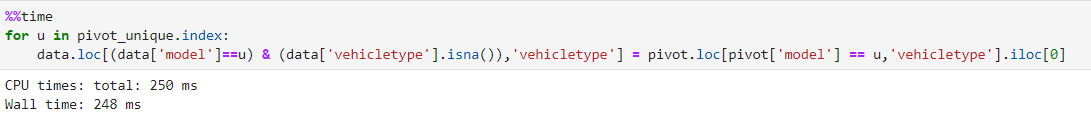

In [28]:
data.isna().sum().sort_values(ascending = False)

vehicletype          27448
fueltype             25732
gearbox              15702
datecrawled              0
price                    0
registrationyear         0
power                    0
model                    0
kilometer                0
registrationmonth        0
brand                    0
repaired                 0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

в любом случае ещё 3к строк удалось сохранить 

вообще это у нас категориальный признак , и мы можем добавить категорию неизвестно , мне кажется будет вполне справедливо в любом случае всё что я заполню таким образом потом попробуем удалить и посмотрим разниц 

но вот опять же делема можно ли записать всё в other или нужно делать отдельнуб категорию (спойлер принял решение other == "неизвестно"

In [29]:
data[data['vehicletype'] == 'other']

datecrawled  price vehicletype  registrationyear gearbox  \
36      2016-03-11 11:50:37   1600       other              1991  manual   
38      2016-04-01 17:45:07  11900       other              2002  manual   
76      2016-03-11 14:50:52   1400       other              2003  manual   
191     2016-04-03 11:44:17    550       other              1997  manual   
433     2016-04-02 21:54:46   5500       other              2010  manual   
...                     ...    ...         ...               ...     ...   
353906  2016-03-14 20:37:15   2999       other              1989  manual   
353960  2016-03-07 19:56:04   2399       other              1998  manual   
353996  2016-03-07 18:44:17    540       other              1996  manual   
354260  2016-03-09 17:59:03    399       other              1994     NaN   
354283  2016-03-22 09:51:42   7500       other              2009  manual   

        power        model  kilometer  registrationmonth  fueltype  \
36         75       kadett      70000                  0       NaN   
38        129        other     150000                 11  gasoline   
76         82         vito     150000                  8  gasoline   
191        75         golf     150000                  6    petrol   
433       120        other     150000                  7  gasoline   
...       ...          ...        ...                ...       ...   
353906     45  transporter     150000                 11  gasoline   
353960     79         vito     150000                 10  gasoline   
353996      0        caddy     150000                  0  gasoline   
354260   1103          3er     150000                  0       NaN   
354283    120      3_reihe     100000                 12    petrol   

                brand repaired          datecreated  numberofpictures  \
36               opel       no  2016-03-11 00:00:00                 0   
38         volkswagen       no  2016-04-01 00:00:00                 0   
76      mercedes_benz       no  2016-03-11 00:00:00                 0   
191        volkswagen       no  2016-04-03 00:00:00                 0   
433           citroen       no  2016-04-02 00:00:00                 0   
...               ...      ...                  ...               ...   
353906     volkswagen       no  2016-03-14 00:00:00                 0   
353960  mercedes_benz       no  2016-03-07 00:00:00                 0   
353996     volkswagen       no  2016-03-07 00:00:00                 0   
354260            bmw       no  2016-03-09 00:00:00                 0   
354283        peugeot       no  2016-03-22 00:00:00                 0   

        postalcode             lastseen  
36            2943  2016-04-07 03:46:09  
38           10551  2016-04-05 12:47:30  
76            4668  2016-03-11 14:50:52  
191          96175  2016-04-07 12:45:02  
433           7545  2016-04-02 22:44:37  
...            ...                  ...  
353906       26632  2016-03-24 00:46:24  
353960       24109  2016-03-19 22:47:00  
353996       99510  2016-04-07 02:18:01  
354260       56235  2016-03-17 09:17:08  
354283       53844  2016-03-22 10:41:49  

[2811 rows x 16 columns]

вижу модель other , выше принял решение что удаляем все строки где нет модели машины. Объясню почему модель так важна . По сути модель == начальная стоимость авто. А этот параметр очень важен чтобы понять модели да и человеку от какой суммы отталкиваться 

In [30]:
data = data[~(data['model'] == 'other')]

In [31]:
data.isna().sum().sort_values(ascending = False)

vehicletype          25970
fueltype             23773
gearbox              14306
datecrawled              0
price                    0
registrationyear         0
power                    0
model                    0
kilometer                0
registrationmonth        0
brand                    0
repaired                 0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

ещё 1000 строк почистили 

так и что можно сказать про other так очень много разноплановых машин , поэтому впринципе можно в other все nan закинуть 

In [32]:
data['vehicletype'] = data['vehicletype'].fillna('other')

с типом топлива такое не прокатит 

In [33]:
data['fueltype'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'cng', 'electric',
       'hybrid'], dtype=object)

изучив данные в интернете пришёл к выводу что вообще машины с завода ездят на топливе и газовое оборудование ставится отдельно и увеличивает стоимость , но разница в типе газа не особо влияет на стоимость , тоесть машина на lpg и на cng будут стоить +- одинаково , поэтому заменим все типы газа на gasoline

In [34]:
data.loc[data['fueltype'] == 'lpg','fueltype'] = 'gasoline'
data.loc[data['fueltype'] == 'cng','fueltype'] = 'gasoline'

In [35]:
data['fueltype'].unique()

array(['petrol', 'gasoline', nan, 'other', 'electric', 'hybrid'],
      dtype=object)

что блин значит тип топлива другой (спойлер пришёл к выводу что other == "дизель", но опять же не все , а лишь часть поэтому с other ничего не сделаешь)

In [36]:
data[data['fueltype'] == 'other'].head()

datecrawled  price vehicletype  registrationyear gearbox  \
363    2016-03-14 23:52:32   6500       sedan              2007  manual   
392    2016-03-25 18:56:32   2350       small              2006     NaN   
10584  2016-03-17 15:49:34    900       sedan              2002  manual   
12003  2016-03-28 19:52:15      0       small              1983  manual   
15016  2016-03-23 18:36:18   1400       wagon              1998    auto   

       power     model  kilometer  registrationmonth fueltype          brand  \
363      125     focus     125000                  9    other           ford   
392        0        c1       5000                  0    other        citroen   
10584     85     focus     150000                 10    other           ford   
12003     26       601      80000                  8    other        trabant   
15016    150  e_klasse     150000                  1    other  mercedes_benz   

      repaired          datecreated  numberofpictures  postalcode  \
363         no  2016-03-14 00:00:00                 0       97199   
392         no  2016-03-25 00:00:00                 0       26123   
10584       no  2016-03-17 00:00:00                 0       40233   
12003       no  2016-03-28 00:00:00                 0       53945   
15016      yes  2016-03-23 00:00:00                 0       12055   

                  lastseen  
363    2016-04-05 11:51:03  
392    2016-04-07 00:46:08  
10584  2016-04-06 23:46:59  
12003  2016-04-07 02:17:45  
15016  2016-04-03 23:17:22

применяем тот же алгоритм что и для repaired

In [37]:
pivot = data.pivot_table(values = 'repaired',index = ['model','fueltype','brand'],aggfunc = 'count')
pivot = pivot.reset_index()
pivot

model  fueltype       brand  repaired
0        100  gasoline        audi        23
1        100    petrol        audi       359
2        145  gasoline  alfa_romeo         1
3        145    petrol  alfa_romeo        43
4        147  gasoline  alfa_romeo       151
..       ...       ...         ...       ...
582  z_reihe  gasoline         bmw        12
583  z_reihe    petrol         bmw       683
584   zafira  gasoline        opel      1399
585   zafira    hybrid        opel         1
586   zafira    petrol        opel      1387

[587 rows x 4 columns]

In [38]:
pivot_unique_1 = pivot.value_counts(['model'])[pivot.value_counts(['model']) == 1]
pivot_unique_1

model             
r19                   1
amarok                1
materia               1
200                   1
gl                    1
boxster               1
elefantino            1
kadett                1
move                  1
90                    1
range_rover_evoque    1
911                   1
charade               1
dtype: int64

In [39]:
for u in pivot_unique_1.index:
    data.loc[(data['model']==u[0]) & (data['fueltype'].isna()),'fueltype'] = pivot.loc[pivot['model'] == u[0],'fueltype'].iloc[0]

In [40]:
data.isna().sum().sort_values(ascending = False)

fueltype             23615
gearbox              14306
datecrawled              0
price                    0
vehicletype              0
registrationyear         0
power                    0
model                    0
kilometer                0
registrationmonth        0
brand                    0
repaired                 0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

мдэ)

<div class="alert alert-warning">
<b>Комментарий </b>

я осознанно не пишу функцию , из-за того что данные разного рода , чтобы не пустить их особенности , я делаю всё вручную 
</div>

In [41]:
pivot = data.pivot_table(values = 'repaired',index = ['model','fueltype','brand','registrationyear'],aggfunc = 'count')
pivot = pivot.reset_index()
pivot

model  fueltype brand  registrationyear  repaired
0        100  gasoline  audi              1979         1
1        100  gasoline  audi              1980         1
2        100  gasoline  audi              1986         1
3        100  gasoline  audi              1990         3
4        100  gasoline  audi              1991         4
...      ...       ...   ...               ...       ...
7749  zafira    petrol  opel              2014         8
7750  zafira    petrol  opel              2015         3
7751  zafira    petrol  opel              2016        29
7752  zafira    petrol  opel              2017        42
7753  zafira    petrol  opel              2018        14

[7754 rows x 5 columns]

In [42]:
pivot_unique = pivot.value_counts(['model','registrationyear'])[pivot.value_counts(['model','registrationyear']) == 1]
pivot_unique

model     registrationyear
x_type    1994                1
transit   1975                1
          1976                1
stilo     2008                1
scirocco  1982                1
                             ..
glk       2010                1
          2011                1
          2012                1
          2017                1
zafira    3700                1
Length: 2336, dtype: int64

In [43]:
%%time
for u in pivot_unique.index:
    data.loc[(data['model']==u[0]) & (data['registrationyear']==u[1]) & (data['fueltype'].isna()),'fueltype'] = \
    pivot.loc[(pivot['model'] == u[0]) & (pivot['registrationyear']==u[1]),'fueltype'].iloc[0]

CPU times: total: 48.5 s
Wall time: 48.7 s


In [44]:
data.isna().sum().sort_values(ascending = False)

fueltype             21214
gearbox              14306
datecrawled              0
price                    0
vehicletype              0
registrationyear         0
power                    0
model                    0
kilometer                0
registrationmonth        0
brand                    0
repaired                 0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

опа сократили до 20 и вот тут делема other ...

объясню в чём основная делема , если мы все пропуски изменяем на other , мы вносим неточность. Так как это не отражает реальную картину . В этом ничего сверх критичного нет. Но например при анализе увидем что например тип кузова обладает высокой кардинальностью и нам придётся использовать что-то по типу Target Encoding. следовательно у нас всё заполниться числами и вот в этом и прикол заполнение other приведёт к заполнению каким-то числом ,которое не совсем отражает данные => это может уменьшить важность фичи => меньшая устойчивость модели к экстермальным значениям в фичах с высокой важностью

In [45]:
data[data['fueltype'].isna()]

datecrawled  price  vehicletype  registrationyear gearbox  \
9       2016-03-17 10:53:50    999        small              1998  manual   
13      2016-03-21 21:37:40   2500        wagon              2004  manual   
41      2016-03-30 20:38:20   7500        sedan              2002    auto   
54      2016-03-17 07:56:40   4700        wagon              2005  manual   
65      2016-03-28 17:41:27  10900        other              2017  manual   
...                     ...    ...          ...               ...     ...   
354327  2016-03-14 11:51:01   2999        wagon              2004  manual   
354329  2016-03-30 20:55:30    350        small              1996     NaN   
354339  2016-03-20 12:46:00   3850  convertible              2006  manual   
354346  2016-03-07 17:06:35   2600        other              2005    auto   
354361  2016-03-09 13:37:43   5250        other              2016    auto   

        power     model  kilometer  registrationmonth fueltype          brand  \
9         101      golf     150000                  0      NaN     volkswagen   
13        131    passat     150000                  2      NaN     volkswagen   
41        306  e_klasse     150000                  4      NaN  mercedes_benz   
54          0    signum     150000                  0      NaN           opel   
65        101     astra      50000                  3      NaN           opel   
...       ...       ...        ...                ...      ...            ...   
354327    234    vectra     100000                  1      NaN           opel   
354329     65     punto     150000                  0      NaN           fiat   
354339    108   2_reihe     125000                  2      NaN        peugeot   
354346      0  c_klasse     150000                  9      NaN  mercedes_benz   
354361    150       159     150000                 12      NaN     alfa_romeo   

       repaired          datecreated  numberofpictures  postalcode  \
9            no  2016-03-17 00:00:00                 0       27472   
13           no  2016-03-21 00:00:00                 0       90762   
41           no  2016-03-30 00:00:00                 0       33649   
54           no  2016-03-17 00:00:00                 0       88433   
65           no  2016-03-28 00:00:00                 0       63607   
...         ...                  ...               ...         ...   
354327       no  2016-03-14 00:00:00                 0       83364   
354329       no  2016-03-30 00:00:00                 0       25436   
354339       no  2016-03-20 00:00:00                 0       53947   
354346       no  2016-03-07 00:00:00                 0       61169   
354361       no  2016-03-09 00:00:00                 0       51371   

                   lastseen  
9       2016-03-31 17:17:06  
13      2016-03-23 02:50:54  
41      2016-04-03 11:44:49  
54      2016-04-04 04:17:32  
65      2016-04-06 23:15:52  
...                     ...  
354327  2016-03-16 23:46:11  
354329  2016-04-07 13:50:41  
354339  2016-03-26 21:18:23  
354346  2016-03-08 21:28:38  
354361  2016-03-13 01:44:13  

[21214 rows x 16 columns]

так что можно придумать ... У нас есть машинки с ДВС и на них можно сверху поставить газовое оборудование по этому впринципе если машины выпускаются с ДВС , но также есть с газовым оборудованием и нет электричек и остального , то можем заполнить бензином 

In [46]:
pivot = data.pivot_table(values = 'repaired',index = ['model','fueltype','brand'],aggfunc = 'count')
pivot = pivot.reset_index()
pivot['sum'] = pivot['brand'] + pivot['model']
pivot = pivot[pivot['repaired'] > 3]
pivot

model  fueltype       brand  repaired            sum
0        100  gasoline        audi        23        audi100
1        100    petrol        audi       368        audi100
3        145    petrol  alfa_romeo        46  alfa_romeo145
4        147  gasoline  alfa_romeo       151  alfa_romeo147
5        147    petrol  alfa_romeo       392  alfa_romeo147
..       ...       ...         ...       ...            ...
581  ypsilon    petrol      lancia       201  lanciaypsilon
582  z_reihe  gasoline         bmw        12     bmwz_reihe
583  z_reihe    petrol         bmw       687     bmwz_reihe
584   zafira  gasoline        opel      1399     opelzafira
586   zafira    petrol        opel      1390     opelzafira

[473 rows x 5 columns]

In [47]:
pivot.sort_values(by = 'repaired').head(20)

model  fueltype          brand  repaired                    sum
116         aygo  gasoline         toyota         4             toyotaaygo
356      m_reihe  gasoline            bmw         4             bmwm_reihe
222    discovery    petrol     land_rover         4    land_roverdiscovery
477      serie_2  gasoline     land_rover         4      land_roverserie_2
200        corsa     other           opel         4              opelcorsa
478      serie_2    petrol     land_rover         4      land_roverserie_2
488           sl  gasoline  mercedes_benz         4        mercedes_benzsl
528  transporter     other     volkswagen         5  volkswagentransporter
218        delta  gasoline         lancia         5            lanciadelta
229       ducato    petrol           fiat         5             fiatducato
208    crossfire  gasoline       chrysler         5      chryslercrossfire
106        astra     other           opel         5              opelastra
562       vivaro    petrol           opel         5             opelvivaro
252        focus     other           ford         5              fordfocus
380         musa  gasoline         lancia         5             lanciamusa
473     seicento  gasoline           fiat         6           fiatseicento
303         jazz    hybrid          honda         6              hondajazz
448     roadster  gasoline          smart         6          smartroadster
346        lodgy    petrol          dacia         7             dacialodgy
293           i3    petrol            bmw         7                  bmwi3

как мы видем есть единичные экземпляры электричек и тому подобного , это является довольно сильной особенность , я думаю люди бы указали это в 

In [48]:
pivot2 = pivot.pivot_table(values = 'fueltype',index = ['model','brand'],aggfunc = 'sum')['fueltype']
pivot2 = pivot2.reset_index()
pivot2['fueltype'].unique()

array(['gasolinepetrol', 'petrol', 'otherpetrol', 'gasoline',
       'gasolineotherpetrol', 'gasolinehybridpetrol',
       'electricgasolinepetrol', 'hybridpetrol'], dtype=object)

In [49]:
pivot2

model       brand              fueltype
0        100        audi        gasolinepetrol
1        145  alfa_romeo                petrol
2        147  alfa_romeo        gasolinepetrol
3        156  alfa_romeo        gasolinepetrol
4        159  alfa_romeo        gasolinepetrol
..       ...         ...                   ...
246    yaris      toyota  gasolinehybridpetrol
247     yeti       skoda        gasolinepetrol
248  ypsilon      lancia        gasolinepetrol
249  z_reihe         bmw        gasolinepetrol
250   zafira        opel        gasolinepetrol

[251 rows x 3 columns]

есть модели авто , которые имеют довольно странные значения electric gasoline hybrid petrol 

In [50]:
array_actual = ['gasolinepetrol','gasolineotherpetrol','otherpetrol']

In [51]:
pivot2 = pivot2[pivot2['fueltype'] == ('gasolinepetrol' or 'gasolineotherpetrol' or 'otherpetrol')]
pivot2 = pivot2.reset_index(drop = True)

а вот и заполнение топлимов всех nan у моделей имеющий сумарный тип топлива 'gasolinepetrol','gasolineotherpetrol','otherpetrol'

In [52]:
pivot2

model       brand        fueltype
0         100        audi  gasolinepetrol
1         147  alfa_romeo  gasolinepetrol
2         156  alfa_romeo  gasolinepetrol
3         159  alfa_romeo  gasolinepetrol
4     1_reihe     peugeot  gasolinepetrol
..        ...         ...             ...
195  xc_reihe       volvo  gasolinepetrol
196      yeti       skoda  gasolinepetrol
197   ypsilon      lancia  gasolinepetrol
198   z_reihe         bmw  gasolinepetrol
199    zafira        opel  gasolinepetrol

[200 rows x 3 columns]

In [53]:
pivot2.loc[0,'model']

'100'

In [54]:
%%time
for u in range(len(pivot2)):
    data.loc[(data['model']==pivot2.loc[u,'model']) & (data['brand']==pivot2.loc[u,'brand']) & (data['fueltype'].isna()),'fueltype'] = 'petrol'

CPU times: total: 6.28 s
Wall time: 6.29 s


In [55]:
data.isna().sum().sort_values(ascending = False)

gearbox              14306
fueltype              6146
datecrawled              0
price                    0
vehicletype              0
registrationyear         0
power                    0
model                    0
kilometer                0
registrationmonth        0
brand                    0
repaired                 0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

уже лучше остальное в other 

In [56]:
data['fueltype'] = data['fueltype'].fillna('other')

In [57]:
data['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

теперь тоже самое с gearbox

In [58]:
pivot = data.pivot_table(values = 'repaired',index = ['model','gearbox','brand'],aggfunc = 'count')
pivot = pivot.reset_index()
pivot

model gearbox       brand  repaired
0        100    auto        audi        63
1        100  manual        audi       336
2        145  manual  alfa_romeo        40
3        147    auto  alfa_romeo        29
4        147  manual  alfa_romeo       520
..       ...     ...         ...       ...
493  ypsilon  manual      lancia       185
494  z_reihe    auto         bmw        76
495  z_reihe  manual         bmw       625
496   zafira    auto        opel       308
497   zafira  manual        opel      2573

[498 rows x 4 columns]

In [59]:
pivot_unique = pivot.value_counts('model')[pivot.value_counts('model') == 1]

In [60]:
%%time
for u in pivot_unique.index:
    data.loc[(data['model']==u) & (data['gearbox'].isna()),'gearbox'] = pivot.loc[pivot['model'] == u,'gearbox'].iloc[0]

CPU times: total: 297 ms
Wall time: 301 ms


In [61]:
data.isna().sum().sort_values(ascending = False)

gearbox              14228
datecrawled              0
price                    0
vehicletype              0
registrationyear         0
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype                 0
brand                    0
repaired                 0
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

ура -70 пропусков 

предлагаю это закодировать как неизвестно , но тут опять же будут побочки 

In [62]:
data['gearbox'] = data['gearbox'].fillna('unknowen')

итоги предобработки : малую часть данных удалось восстановить с достоверной точностью , также не малую часть удалось восстановить с высокой точностью , часть которую нельзя было восстановить с достаточной точностью поместили в other 

### обработка данных

In [63]:
data

datecrawled  price  vehicletype  registrationyear gearbox  \
0       2016-03-24 11:52:17    480        other              1993  manual   
2       2016-03-14 12:52:21   9800          suv              2004    auto   
3       2016-03-17 16:54:04   1500        small              2001  manual   
4       2016-03-31 17:25:20   3600        small              2008  manual   
5       2016-04-04 17:36:23    650        sedan              1995  manual   
...                     ...    ...          ...               ...     ...   
354363  2016-03-27 20:36:20   1150          bus              2000  manual   
354364  2016-03-21 09:50:58      0        other              2005  manual   
354366  2016-03-05 19:56:21   1199  convertible              2000    auto   
354367  2016-03-19 18:57:12   9200          bus              1996  manual   
354368  2016-03-20 19:41:08   3400        wagon              2002  manual   

        power        model  kilometer  registrationmonth  fueltype  \
0           0         golf     150000                  0    petrol   
2         163        grand     125000                  8  gasoline   
3          75         golf     150000                  6    petrol   
4          69        fabia      90000                  7  gasoline   
5         102          3er     150000                 10    petrol   
...       ...          ...        ...                ...       ...   
354363      0       zafira     150000                  3    petrol   
354364      0         colt     150000                  7    petrol   
354366    101       fortwo     125000                  3    petrol   
354367    102  transporter     150000                  3  gasoline   
354368    100         golf     150000                  6  gasoline   

             brand repaired          datecreated  numberofpictures  \
0       volkswagen       no  2016-03-24 00:00:00                 0   
2             jeep       no  2016-03-14 00:00:00                 0   
3       volkswagen       no  2016-03-17 00:00:00                 0   
4            skoda       no  2016-03-31 00:00:00                 0   
5              bmw      yes  2016-04-04 00:00:00                 0   
...            ...      ...                  ...               ...   
354363        opel       no  2016-03-27 00:00:00                 0   
354364  mitsubishi      yes  2016-03-21 00:00:00                 0   
354366       smart       no  2016-03-05 00:00:00                 0   
354367  volkswagen       no  2016-03-19 00:00:00                 0   
354368  volkswagen       no  2016-03-20 00:00:00                 0   

        postalcode             lastseen  
0            70435  2016-04-07 03:16:57  
2            90480  2016-04-05 12:47:46  
3            91074  2016-03-17 17:40:17  
4            60437  2016-04-06 10:17:21  
5            33775  2016-04-06 19:17:07  
...            ...                  ...  
354363       26624  2016-03-29 10:17:23  
354364        2694  2016-03-21 10:42:49  
354366       26135  2016-03-11 18:17:12  
354367       87439  2016-04-07 07:15:26  
354368       40764  2016-03-24 12:45:21  

[310240 rows x 16 columns]

даты нам не нужны запомним, что датасет составлен в 2016 году

In [64]:
data = data.drop(['numberofpictures','datecrawled','datecreated','postalcode','registrationmonth','lastseen'],axis = 1)

In [65]:
data

price  vehicletype  registrationyear gearbox  power        model  \
0         480        other              1993  manual      0         golf   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
5         650        sedan              1995  manual    102          3er   
...       ...          ...               ...     ...    ...          ...   
354363   1150          bus              2000  manual      0       zafira   
354364      0        other              2005  manual      0         colt   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        kilometer  fueltype       brand repaired  
0          150000    petrol  volkswagen       no  
2          125000  gasoline        jeep       no  
3          150000    petrol  volkswagen       no  
4           90000  gasoline       skoda       no  
5          150000    petrol         bmw      yes  
...           ...       ...         ...      ...  
354363     150000    petrol        opel       no  
354364     150000    petrol  mitsubishi      yes  
354366     125000    petrol       smart       no  
354367     150000  gasoline  volkswagen       no  
354368     150000  gasoline  volkswagen       no  

[310240 rows x 10 columns]

будем кодировать после избавления от выбросов

In [66]:
data.select_dtypes(exclude='number').columns

Index(['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired'], dtype='object')

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310240 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             310240 non-null  int64 
 1   vehicletype       310240 non-null  object
 2   registrationyear  310240 non-null  int64 
 3   gearbox           310240 non-null  object
 4   power             310240 non-null  int64 
 5   model             310240 non-null  object
 6   kilometer         310240 non-null  int64 
 7   fueltype          310240 non-null  object
 8   brand             310240 non-null  object
 9   repaired          310240 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


In [68]:
data['registrationyear'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 2017, 1981, 2003, 1994, 1991, 1990,
       2006, 1999, 2012, 2010, 2013, 2000, 1992, 1996, 1985, 1989, 2015,
       1976, 1983, 1973, 1969, 1987, 1986, 1982, 1988, 1980, 1971, 1984,
       1970, 1978, 1966, 1977, 1974, 1963, 1960, 5000, 1954, 1979, 1972,
       1967, 1000, 1500, 2200, 1964, 3000, 1968, 2066, 9999, 1975, 2019,
       1959, 9000, 2900, 5900, 1945, 5911, 1400, 1961, 4000, 8000, 1200,
       8500, 1962, 3700, 1965, 1234, 1936, 1923, 2290, 1952, 7000, 1930,
       1938, 1956, 1800, 5555, 1950, 1300, 1111, 7100, 2500, 8200, 1958,
       1600], dtype=int64)

1111 и другие интересные значения

In [69]:
FTS_NU = ['price','registrationyear','power','kilometer']

In [70]:
for item in FTS_NU:
    pd.to_numeric(data[item],downcast='float')

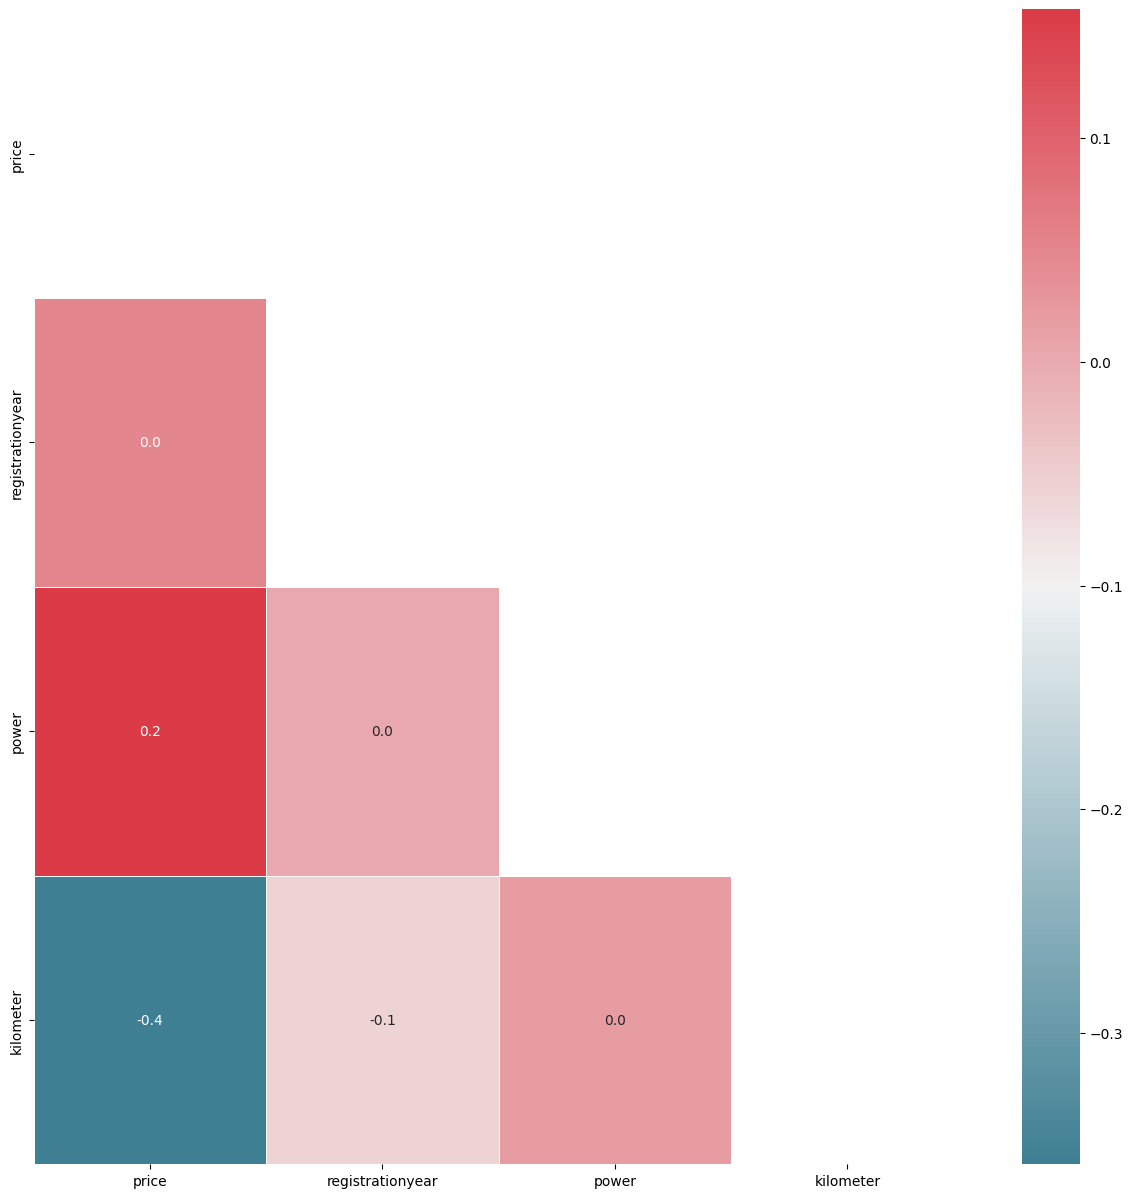

In [71]:
corr1 = data[FTS_NU].corr()
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15)) 
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
sns.heatmap(corr1, cmap=cmap, linewidths=.5, mask=mask, annot=True, fmt=".1f") 
plt.show()

сильных кореляций не обнаружено

In [72]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [73]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data[FTS_NU].index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))   

In [74]:
comparison_table, std_outliers = get_column_outliers(data[FTS_NU])
anomalies_report(std_outliers)

Total number of outliers: 9477
Percentage of outliers:   3.05%


In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


In [75]:
comparison_table

upper_bound   lower_bound  anomalies_count  \
price              18069.491095  -9046.824379           4235.0   
registrationyear    2189.047247   1819.120385             77.0   
power                673.701964   -451.345182            292.0   
kilometer         239340.036743  18607.874552           5116.0   

                  anomalies_percentage  
price                         1.365072  
registrationyear              0.024819  
power                         0.094121  
kilometer                     1.649046

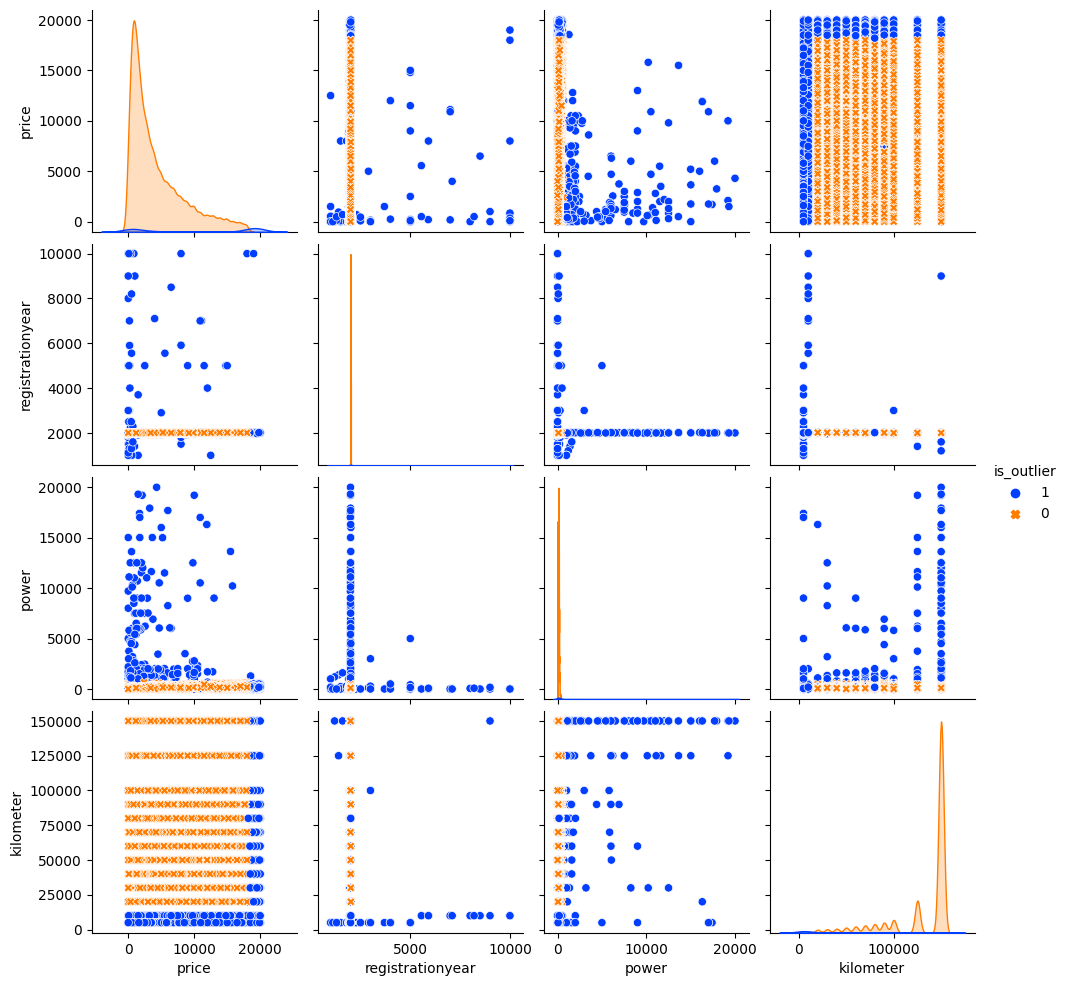

In [76]:
labeled_data = data[FTS_NU].copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = FTS_NU,
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

где моя счётка для чистки данных , всё выглядит плохо)

In [77]:
data.shape

(310240, 10)

In [78]:
data = data[data['registrationyear'] > 1909]
data = data[data['registrationyear'] < 2017]
data = data[data['power'] < 1100]
data = data[data['price'] > 0]

эти единичные значения уберём , они нам будут только мешать (цифры обрезания были взяты из анализа таблицы выше)

In [79]:
data[data['power'] == 0]

price vehicletype  registrationyear   gearbox  power      model  \
0         480       other              1993    manual      0       golf   
15        450       small              1910  unknowen      0         ka   
32        245       sedan              1994  unknowen      0       golf   
37       1500       other              2016  unknowen      0     kangoo   
54       4700       wagon              2005    manual      0     signum   
...       ...         ...               ...       ...    ...        ...   
354332   7900         bus              2007    manual      0   b_klasse   
354335    390       small              1997      auto      0      corsa   
354336   3299       other              2005      auto      0  outlander   
354346   2600       other              2005      auto      0   c_klasse   
354363   1150         bus              2000    manual      0     zafira   

        kilometer  fueltype          brand repaired  
0          150000    petrol     volkswagen       no  
15           5000    petrol           ford       no  
32         150000    petrol     volkswagen       no  
37         150000  gasoline        renault       no  
54         150000    petrol           opel       no  
...           ...       ...            ...      ...  
354332     125000    petrol  mercedes_benz       no  
354335     100000    petrol           opel      yes  
354336     150000    petrol     mitsubishi       no  
354346     150000    petrol  mercedes_benz       no  
354363     150000    petrol           opel       no  

[25761 rows x 10 columns]

In [80]:
data.shape

(290745, 10)

очень сильное сокращение датасета по хорошему вообще попробовать мощность восстановить 

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


Total number of outliers: 12020
Percentage of outliers:   4.13%
CPU times: total: 1min 19s
Wall time: 1min 19s


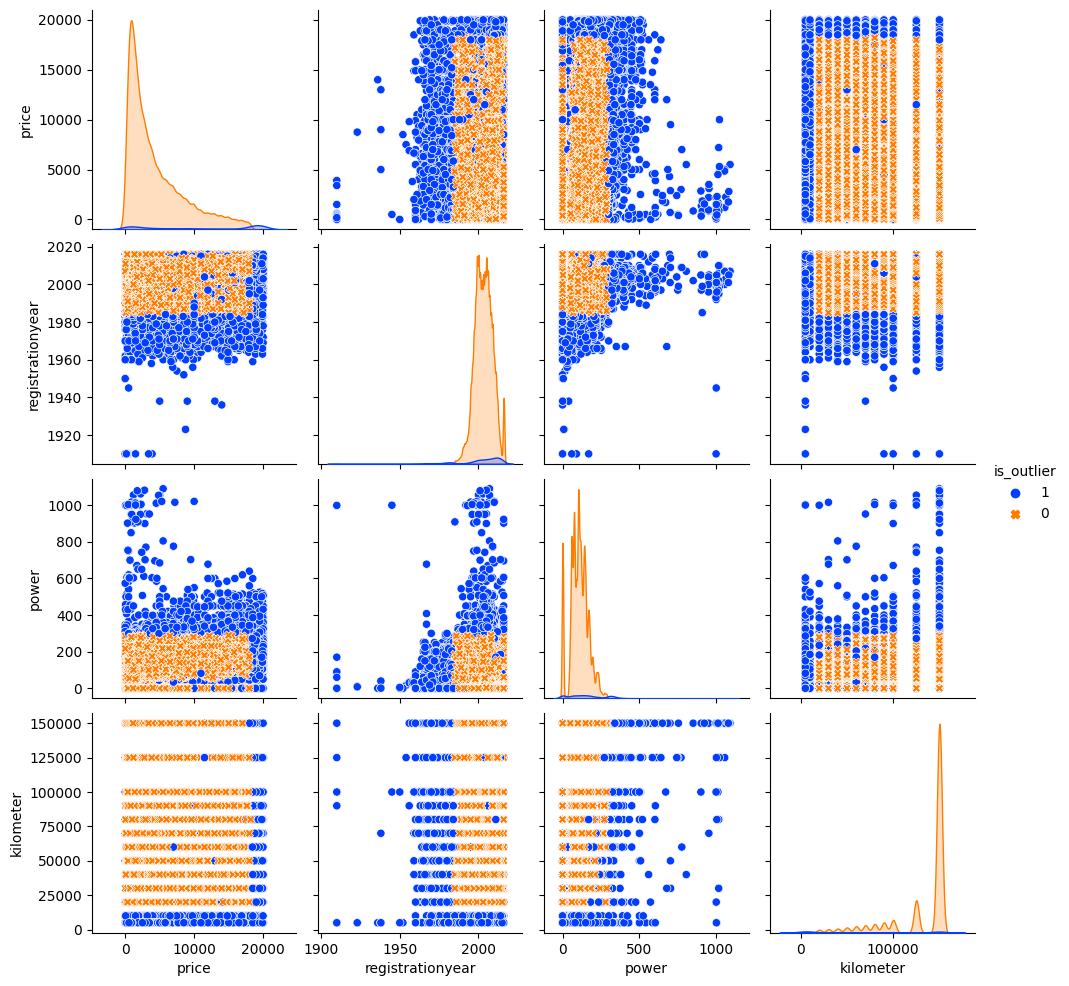

In [81]:
%%time
comparison_table, std_outliers = get_column_outliers(data[FTS_NU])
anomalies_report(std_outliers)
labeled_data = data[FTS_NU].copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = FTS_NU,
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

но всё равно уже лучше , сейчас подумаю что с данными делать

In [82]:
data.sort_values('registrationyear').head(30)

price  vehicletype  registrationyear   gearbox  power    model  \
142990     30        other              1910  unknowen      0  calibra   
304262    150        small              1910    manual      0       ka   
203777    180        other              1910    manual      0   mondeo   
321995    180        other              1910    manual      0   mondeo   
62803    3400        small              1910    manual     90   beetle   
48958     600        small              1910    manual      0    agila   
35943     200        other              1910  unknowen      0    caddy   
318111      1        other              1910  unknowen      0     golf   
29516      80        small              1910  unknowen      0    punto   
203230    400        other              1910    manual    170      3er   
261973    189        other              1910  unknowen      0   escort   
82829     500        other              1910  unknowen      0    corsa   
74814     400        other              1910  unknowen     60     golf   
276318    300        other              1910  unknowen      0     polo   
127400     99        other              1910  unknowen      0       a2   
23750    3900        wagon              1910    manual     90   passat   
223945   1500          bus              1910    manual    999   espace   
203985    222        other              1910    manual      0     golf   
151280    300        other              1910    manual      0     golf   
15        450        small              1910  unknowen      0       ka   
144388     50        other              1910  unknowen      0   kaefer   
58883       1        other              1910  unknowen      0      3er   
324049   8750  convertible              1923    manual      8       c3   
117371   8750  convertible              1923    manual     11       c3   
108326  14000        sedan              1936  unknowen      0      500   
146207  12999        small              1938    manual     40  2_reihe   
335547   9000        sedan              1938    manual      1   kadett   
271260   5000        sedan              1938    manual      0   kadett   
52323     500        small              1945    manual   1000    astra   
275026      2        sedan              1950      auto      5     leon   

        kilometer  fueltype       brand repaired  
142990     100000     other        opel       no  
304262       5000    petrol        ford      yes  
203777     150000    petrol        ford      yes  
321995     150000    petrol        ford      yes  
62803       90000    petrol  volkswagen       no  
48958        5000    petrol        opel      yes  
35943      150000  gasoline  volkswagen       no  
318111     125000    petrol  volkswagen       no  
29516      150000    petrol        fiat       no  
203230       5000    petrol         bmw       no  
261973     150000    petrol        ford       no  
82829      150000     other        opel       no  
74814      150000    petrol  volkswagen       no  
276318       5000    petrol  volkswagen       no  
127400       5000    petrol        audi       no  
23750      150000    petrol  volkswagen       no  
223945     150000    petrol     renault       no  
203985       5000    petrol  volkswagen       no  
151280     150000    petrol  volkswagen       no  
15           5000    petrol        ford       no  
144388       5000     other  volkswagen       no  
58883      150000    petrol         bmw       no  
324049       5000    petrol     citroen       no  
117371       5000    petrol     citroen       no  
108326       5000    petrol        fiat       no  
146207      70000    petrol     peugeot       no  
335547       5000    petrol        opel       no  
271260       5000    petrol        opel       no  
52323      100000     other        opel      yes  
275026       5000  gasoline        seat       no

In [83]:
data[data['registrationyear'] < 1990].shape

(4420, 10)

как много неточностей , вообще можно было бы подключиться к базе данных и вытащить инфрормацию о моделях (лошадинные силы , год выхода) от туда , но все платные((( 

In [84]:
auxiliary_data = pd.read_csv('https://raw.githubusercontent.com/verydirtyhands/datas14/main/csv.csv',
                             sep = ';',
                             names = ['brand','model','registrationyear','-'])

максимум что нашёл базу данных (не полную) с моделями марками и годами выхода , вот её и используем для заполнения

In [85]:
auxiliary_data = auxiliary_data.drop('-',axis = 1)

In [86]:
auxiliary_data['brand'] = auxiliary_data['brand'].str.replace(' ','_').str.lower()
auxiliary_data['model'] = auxiliary_data['model'].str.replace(' ','_').str.lower()
auxiliary_data

brand    model  registrationyear
0     acura      cdx              2016
1     acura       cl              1998
2     acura       el              1997
3     acura      ilx              2012
4     acura  integra              1995
...     ...      ...               ...
1330  volvo      v90              1997
1331  volvo     xc40              2017
1332  volvo     xc60              2008
1333  volvo     xc70              2001
1334  volvo     xc90              2002

[1335 rows x 3 columns]

In [87]:
data['brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'audi', 'alfa_romeo', 'subaru', 'volvo',
       'kia', 'hyundai', 'mitsubishi', 'citroen', 'chevrolet', 'dacia',
       'daihatsu', 'toyota', 'chrysler', 'suzuki', 'daewoo', 'porsche',
       'lancia', 'jaguar', 'land_rover', 'saab', 'lada', 'rover',
       'trabant'], dtype=object)

In [88]:
auxiliary_data['brand'].unique()

array(['acura', 'alfa_romeo', 'aston_martin', 'audi', 'bentley', 'bmw',
       'brilliance', 'bugatti', 'buick', 'byd', 'cadillac', 'changan',
       'chery', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo',
       'daihatsu', 'datsun', 'dodge', 'dongfeng', 'exeed', 'faw',
       'ferrari', 'fiat', 'fisker', 'ford', 'foton', 'gac', 'gaz',
       'geely', 'genesis', 'gmc', 'great_wall', 'haval', 'holden',
       'honda', 'hummer', 'hyundai', 'infiniti', 'isuzu', 'iveco', 'jac',
       'jaguar', 'jeep', 'kia', 'lamborghini', 'lancia', 'land_rover',
       'lexus', 'lifan', 'lincoln', 'lotus', 'marussia', 'maserati',
       'maybach', 'mazda', 'mclaren', 'mercedes', 'mercury', 'mg', 'mini',
       'mitsubishi', 'nissan', 'opel', 'peugeot', 'plymouth', 'pontiac',
       'porsche', 'ravon', 'renault', 'rolls-royce', 'rover', 'saab',
       'saturn', 'scion', 'seat', 'skoda', 'smart', 'ssang_yong',
       'subaru', 'suzuki', 'tesla', 'toyota', 'uaz', 'vaz', 'volkswagen',
       'volvo'

In [89]:
data.shape

(290745, 10)

я всё думаю как оптимизировать 

можно скрестить brand с model что бы не делать множество переборов

In [90]:
data['temporary'] = data['brand'] + data['model']
auxiliary_data['temporary'] = auxiliary_data['brand'] + auxiliary_data['model']
data['release'] = 0 
for u in auxiliary_data['temporary']:
    data.loc[data['temporary']==u,'release'] = auxiliary_data.loc[(auxiliary_data['temporary'] == u) ,'registrationyear'].iloc[0]

уточнил ,можно использовать векторные операции , но пока только буду изучать как их правильно делать

если бы у нас была база данных с информацией о характеристиках автомобиля , мы бы смогли заполнить все пропуски и найти выбросы с высокой точностью , также добавили бы новые фичи например дата релиза


In [91]:
data

price  vehicletype  registrationyear gearbox  power        model  \
0         480        other              1993  manual      0         golf   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
5         650        sedan              1995  manual    102          3er   
...       ...          ...               ...     ...    ...          ...   
354362   3200        sedan              2004  manual    225         leon   
354363   1150          bus              2000  manual      0       zafira   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        kilometer  fueltype       brand repaired              temporary  \
0          150000    petrol  volkswagen       no         volkswagengolf   
2          125000  gasoline        jeep       no              jeepgrand   
3          150000    petrol  volkswagen       no         volkswagengolf   
4           90000  gasoline       skoda       no             skodafabia   
5          150000    petrol         bmw      yes                 bmw3er   
...           ...       ...         ...      ...                    ...   
354362     150000    petrol        seat      yes               seatleon   
354363     150000    petrol        opel       no             opelzafira   
354366     125000    petrol       smart       no            smartfortwo   
354367     150000  gasoline  volkswagen       no  volkswagentransporter   
354368     150000  gasoline  volkswagen       no         volkswagengolf   

        release  
0          1991  
2             0  
3          1991  
4          1999  
5             0  
...         ...  
354362     1999  
354363     1999  
354366     1997  
354367     1990  
354368     1991  

[290745 rows x 12 columns]

In [92]:
data['release'].value_counts()

0       83855
1998    31201
1991    26726
2000    26439
1995    21325
2001    18666
1996    12842
2002    11016
1999    10757
2003    10714
1997     6505
1993     6033
1990     4729
2004     4192
2007     3079
2005     3067
1994     2748
2006     1892
2008     1739
2011     1353
2010      594
2009      468
2014      342
2012      246
1992      209
2013        8
Name: release, dtype: int64

мы сможем проверить 80% данных , я показал концепцию как бы я это сделал если бы уже где-то работал) а пока продолжаем

хехе 25к машин зарегистрировали раньше чем вышли машины) 

если машина зарегистрирована раньше чем вышла , заменим год регистрации на год выхода

In [93]:
for index, row in data.iterrows():
    if row['release'] > row['registrationyear']:
        data.loc[index,'registrationyear'] = row['release']

In [94]:
data[data['release'] > data['registrationyear']]

Empty DataFrame
Columns: [price, vehicletype, registrationyear, gearbox, power, model, kilometer, fueltype, brand, repaired, temporary, release]
Index: []

In [95]:
data = data.drop('release',axis = 1)

In [96]:
data = data.drop('temporary',axis = 1)

In [97]:
data.sort_values('registrationyear').head(30)

price  vehicletype  registrationyear   gearbox  power     model  \
142990     30        other              1910  unknowen      0   calibra   
261973    189        other              1910  unknowen      0    escort   
144388     50        other              1910  unknowen      0    kaefer   
58883       1        other              1910  unknowen      0       3er   
203230    400        other              1910    manual    170       3er   
335547   9000        sedan              1938    manual      1    kadett   
146207  12999        small              1938    manual     40   2_reihe   
271260   5000        sedan              1938    manual      0    kadett   
233059   6900        sedan              1956    manual     30    kaefer   
157929   9800        small              1956    manual     34    kaefer   
334714   3800        sedan              1958    manual     30    kaefer   
125255   1995        small              1959    manual     30    kaefer   
343086   2000        small              1959    manual     30    kaefer   
38974   18500        sedan              1959    manual     30    kaefer   
209039  14900        sedan              1959    manual     48  b_klasse   
91117    5500        other              1960  unknowen      0    kaefer   
234173     20  convertible              1960    manual     50    kaefer   
349688      1        other              1960  unknowen      0       601   
66834     255        other              1960  unknowen      0    kaefer   
291192     99        other              1960  unknowen      0   6_reihe   
54456    1000        other              1960  unknowen      0    kaefer   
330515  14900        sedan              1960    manual     68  b_klasse   
50229    2000        sedan              1960    manual     30    kaefer   
218542     10        other              1960  unknowen      0       601   
113798   9900        sedan              1960  unknowen     34    kaefer   
12087     260        other              1960  unknowen      0    kaefer   
243123    500  convertible              1960  unknowen      0    kaefer   
316924    200        other              1960    manual      0       145   
310021   6600        other              1960  unknowen     30    kaefer   
293048   8750        sedan              1960    manual     30    kaefer   

        kilometer  fueltype          brand repaired  
142990     100000     other           opel       no  
261973     150000    petrol           ford       no  
144388       5000     other     volkswagen       no  
58883      150000    petrol            bmw       no  
203230       5000    petrol            bmw       no  
335547       5000    petrol           opel       no  
146207      70000    petrol        peugeot       no  
271260       5000    petrol           opel       no  
233059     150000    petrol     volkswagen       no  
157929      90000    petrol     volkswagen       no  
334714     150000    petrol     volkswagen       no  
125255      50000    petrol     volkswagen      yes  
343086     100000    petrol     volkswagen      yes  
38974       70000    petrol     volkswagen       no  
209039      70000  gasoline  mercedes_benz       no  
91117      100000    petrol     volkswagen       no  
234173      20000    petrol     volkswagen       no  
349688       5000     other        trabant       no  
66834        5000    petrol     volkswagen       no  
291192     125000    petrol          mazda       no  
54456       40000    petrol     volkswagen       no  
330515     150000    petrol  mercedes_benz      yes  
50229      150000    petrol     volkswagen       no  
218542       5000     other        trabant       no  
113798     100000    petrol     volkswagen       no  
12087       10000    petrol     volkswagen       no  
243123     125000    petrol     volkswagen       no  
316924       5000     other     alfa_romeo       no  
310021       5000    petrol     volkswagen       no  
293048      40000    petrol     volkswagen       no

выбросы остались но их куда меньше , была бы база данных или работа может быть ещё что-нибудь придумали бы , но пока предлагаю просто избавиться от первых двух значений и всё

In [98]:
data = data.drop([203230,146207,77582])

с годом регистрации всё

In [99]:
pivot = data.pivot_table(values = 'power',index = ['model','brand'],aggfunc = ['median'])
pivot = pivot.reset_index()
pivot.sort_values(('median','power'))

model          brand median
                             power
209  serie_1     land_rover    0.0
203   samara           lada    0.0
19       601        trabant   26.0
138   kaefer     volkswagen   34.0
164     move       daihatsu   42.0
..       ...            ...    ...
28       911        porsche  300.0
77        cl  mercedes_benz  306.0
21       6er            bmw  333.0
70   cayenne        porsche  340.0
154  m_reihe            bmw  343.0

[258 rows x 3 columns]

In [100]:
data = data[~((data['model']=='serie_1')&(data['brand']=='land_rover') | (data['model']=='samara')&(data['brand']=='lada')&(data['power']==0))]

я хочу заполнить все выбивающиеся значения медианой , но нам не нужны машины с медианой == 0 

In [101]:
pivot = data.pivot_table(values = 'power',index = ['model','brand'],aggfunc = ['median'])
pivot = pivot.reset_index()
pivot.sort_values(('median','power'))

model          brand median
                             power
19       601        trabant   26.0
138   kaefer     volkswagen   34.0
164     move       daihatsu   42.0
44     arosa           seat   50.0
151     lupo     volkswagen   50.0
..       ...            ...    ...
28       911        porsche  300.0
77        cl  mercedes_benz  306.0
21       6er            bmw  333.0
70   cayenne        porsche  340.0
154  m_reihe            bmw  343.0

[257 rows x 3 columns]

In [102]:
pivot[('median','power')]

0      133.0
1      103.0
2      120.0
3      150.0
4      165.0
       ...  
252     75.0
253    110.0
254     60.0
255    170.0
256    120.0
Name: (median, power), Length: 257, dtype: float64

In [103]:
data[data['power'] >= 500]

price vehicletype  registrationyear gearbox  power     model  \
4060     3100       sedan              2005  manual    953      colt   
5328      500       wagon              1999  manual   1001     astra   
6296      599       small              2002  manual    603     matiz   
6504     3000       small              2009  manual    771     punto   
6637      600       small              2000  manual    603     corsa   
...       ...         ...               ...     ...    ...       ...   
346165  20000       coupe              2016    auto    507   m_reihe   
347016    450       sedan              1996    auto   1004    vectra   
348785  19780       wagon              2003    auto    500  e_klasse   
351947   1500         bus              2001  manual   1001    zafira   
353633   2400       sedan              2007  manual    650        c2   

        kilometer  fueltype          brand repaired  
4060       150000  gasoline     mitsubishi       no  
5328       150000    petrol           opel       no  
6296         5000    petrol      chevrolet      yes  
6504       125000    petrol           fiat       no  
6637       150000    petrol           opel      yes  
...           ...       ...            ...      ...  
346165     150000    petrol            bmw       no  
347016      80000    petrol           opel      yes  
348785     150000    petrol  mercedes_benz       no  
351947       5000  gasoline           opel       no  
353633     150000    petrol        citroen       no  

[144 rows x 10 columns]

если значение мощности отличается в 2+ раза, мы его заменяем на медиану , движки не так сильно отличаются в одинаковых моделий , уж точно не с разницей в 2+ раза

In [104]:
for index, row in pivot.iterrows():
    data.loc[(data['model'] == list(row['model'])[0]) & ((data['power'] <= row[('median','power')] / 2) | (data['power'] >= row[('median','power')] * 2)),'power'] = row[('median','power')]

In [105]:
data

price  vehicletype  registrationyear gearbox  power        model  \
0         480        other              1993  manual  100.0         golf   
2        9800          suv              2004    auto  163.0        grand   
3        1500        small              2001  manual   75.0         golf   
4        3600        small              2008  manual   69.0        fabia   
5         650        sedan              1995  manual  102.0          3er   
...       ...          ...               ...     ...    ...          ...   
354362   3200        sedan              2004  manual  225.0         leon   
354363   1150          bus              2000  manual  120.0       zafira   
354366   1199  convertible              2000    auto  101.0       fortwo   
354367   9200          bus              1996  manual  102.0  transporter   
354368   3400        wagon              2002  manual  100.0         golf   

        kilometer  fueltype       brand repaired  
0          150000    petrol  volkswagen       no  
2          125000  gasoline        jeep       no  
3          150000    petrol  volkswagen       no  
4           90000  gasoline       skoda       no  
5          150000    petrol         bmw      yes  
...           ...       ...         ...      ...  
354362     150000    petrol        seat      yes  
354363     150000    petrol        opel       no  
354366     125000    petrol       smart       no  
354367     150000  gasoline  volkswagen       no  
354368     150000  gasoline  volkswagen       no  

[290734 rows x 10 columns]

In [106]:
data[data['power'] >= 500]

price vehicletype  registrationyear gearbox  power    model  \
17228   14900       coupe              2006    auto  500.0       cl   
17510   15500       coupe              2009    auto  507.0  m_reihe   
20145   18500         suv              2006    auto  521.0  cayenne   
20581   16800         suv              2005    auto  500.0  cayenne   
25684   20000       sedan              2006    auto  507.0  m_reihe   
32693   16999       sedan              2006    auto  515.0       a8   
75230   17999       sedan              2012    auto  560.0  m_reihe   
82421   13500         suv              2006    auto  521.0  cayenne   
92566   20000       sedan              2006    auto  507.0  m_reihe   
96747   13500         suv              2006    auto  521.0  cayenne   
98508   11500         suv              2006    auto  500.0  cayenne   
145438  19800         suv              2007    auto  500.0  cayenne   
149019   8999       sedan              2006    auto  507.0  m_reihe   
161196  15500       coupe              2009    auto  507.0  m_reihe   
173074  11900         suv              2006    auto  521.0  cayenne   
222381  17000       sedan              2006    auto  515.0       a8   
241096   2500       coupe              2005    auto  507.0  m_reihe   
262914  19900       coupe              2005    auto  500.0       cl   
308872  16500       coupe              2000    auto  508.0       cl   
320093  15500       coupe              2009    auto  507.0  m_reihe   
328276  16500       sedan              2005    auto  507.0  m_reihe   
344689  14900         suv              2006    auto  521.0  cayenne   
346165  20000       coupe              2016    auto  507.0  m_reihe   

        kilometer fueltype          brand repaired  
17228      150000   petrol  mercedes_benz      yes  
17510      150000   petrol            bmw      yes  
20145      150000   petrol        porsche       no  
20581      125000   petrol        porsche       no  
25684      150000   petrol            bmw       no  
32693      150000   petrol           audi       no  
75230       40000   petrol            bmw       no  
82421      150000   petrol        porsche      yes  
92566      150000   petrol            bmw       no  
96747      150000   petrol        porsche      yes  
98508       80000   petrol        porsche      yes  
145438     150000   petrol        porsche       no  
149019     100000   petrol            bmw      yes  
161196     150000   petrol            bmw      yes  
173074     125000   petrol        porsche      yes  
222381     150000   petrol           audi       no  
241096     125000   petrol            bmw      yes  
262914     150000   petrol  mercedes_benz       no  
308872      50000   petrol  mercedes_benz      yes  
320093     150000   petrol            bmw      yes  
328276     150000   petrol            bmw       no  
344689     150000   petrol        porsche       no  
346165     150000   petrol            bmw       no

очень хорошо , какое всё чистенькое) 

а теперь моё любимое , давайте поищем несостыковки . Я не так хорош в авто , поэтому не смогу проверить больше

впринципе за год реально наездить 180к , но у нас год только начался поэтому будем считать что машины 2016 года с пробегом 150к выброс
<br>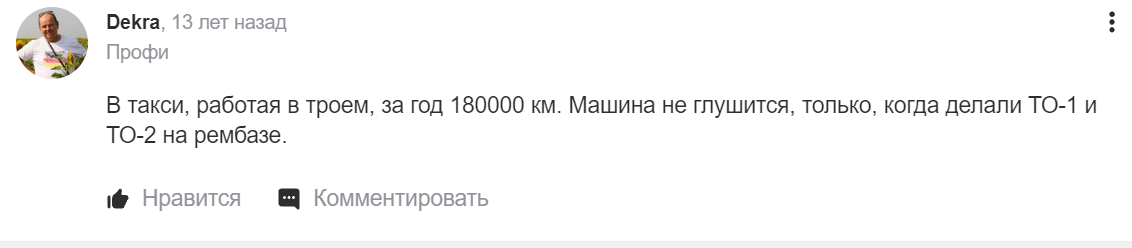

In [107]:
data[(data['kilometer'] >= 100000) & (data['registrationyear'] == 2015)].shape

(24, 10)

In [108]:
data[(data['kilometer'] >= 150000) & (data['registrationyear'] == 2016)].shape

(5717, 10)

хммммм , может данные специально испортили)?

In [109]:
data[(data['kilometer'] >= 150000) & (data['registrationyear'] == 2016) & (data['vehicletype'] != 'other')]

price vehicletype  registrationyear   gearbox  power        model  \
200      1999       small              2016    manual  110.0       almera   
646      1750         bus              2016    manual  116.0       galaxy   
708       480       small              2016  unknowen   68.0       fiesta   
1528     2200       sedan              2016      auto  177.0          5er   
1601     3500         bus              2016    manual  110.0       sharan   
...       ...         ...               ...       ...    ...          ...   
352934   1100       sedan              2016    manual   88.0      3_reihe   
353215   1200       sedan              2016    manual  140.0          5er   
353222   4500         bus              2016    manual  102.0  transporter   
353246   1000       sedan              2016    manual  143.0     c_klasse   
353895    350       sedan              2016    manual   60.0      3_reihe   

        kilometer  fueltype          brand repaired  
200        150000  gasoline         nissan       no  
646        150000  gasoline           ford      yes  
708        150000    petrol           ford       no  
1528       150000    petrol            bmw       no  
1601       150000  gasoline     volkswagen       no  
...           ...       ...            ...      ...  
352934     150000    petrol          mazda      yes  
353215     150000    petrol            bmw       no  
353222     150000  gasoline     volkswagen       no  
353246     150000  gasoline  mercedes_benz       no  
353895     150000    petrol        peugeot       no  

[1039 rows x 10 columns]

я удалять данные не особо хочу, просто взяли на заметку что столб kilometer не является особо информативным , его мы попробуем удалить , я уверен что данные столб практически не будет иметь важности для модели

ну и что у нас получилось 

датасет уменьшился +- на 20% , при условии того что я бы не считал вообще те строчки в которых пропущены модели ибо они не имеют никакого смысла , а лишь мешают и понижают фича импортант

кодировка , я не хочу доверять её всяким там catboost и так далее , поэтому сделаем ручками , но для начала посмотрим что по значениям

In [110]:
data['gearbox'].unique()

array(['manual', 'auto', 'unknowen'], dtype=object)

In [111]:
data['vehicletype'].unique()

array(['other', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe'], dtype=object)

In [112]:
data['fueltype'].unique()

array(['petrol', 'gasoline', 'other', 'hybrid', 'electric'], dtype=object)

всё хорошо

In [113]:
data['brand'].unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'audi', 'alfa_romeo', 'subaru', 'volvo',
       'kia', 'hyundai', 'mitsubishi', 'citroen', 'chevrolet', 'dacia',
       'daihatsu', 'toyota', 'chrysler', 'suzuki', 'daewoo', 'porsche',
       'lancia', 'jaguar', 'land_rover', 'saab', 'lada', 'rover',
       'trabant'], dtype=object)

In [114]:
data = data[~(data['model']=='rangerover')] 
data.loc[data['brand']=='rover','brand'] = 'land_rover'

поправили land rover

In [115]:
data['model'].unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'arosa', 'civic', 'transporter', 'punto', 'e_klasse',
       'clio', 'kadett', 'kangoo', 'one', 'fortwo', '1er', 'b_klasse',
       'signum', 'astra', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra',
       'vito', 'sprinter', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'a4', 'a1', 'insignia', 'combo', 'focus', 'tt', 'corsa',
       'a6', 'jazz', 'omega', 'slk', '7er', '80', '147', '100', 'z_reihe',
       'sorento', 'v40', 'ibiza', 'mustang', 'eos', 'touran', 'getz',
       'a3', 'almera', 'megane', 'lupo', 'r19', 'caddy', 'mondeo',
       'cordoba', 'colt', 'impreza', 'vectra', 'berlingo', 'tiguan',
       'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'zafira', 'mii', 'rx_reihe', '6er',
       'modus', 'fox', 'matiz', 'beetle', 'c1', 'rio', 'touareg', 'logan',
    

вот здесь сложнее , я не эксперт поэтому лучше не буду трогать 

а теперь разбиение на выборки и кодировка

In [116]:
tra_va, test = train_test_split(data,random_state=2077,test_size = 0.2)
train, valid = train_test_split(tra_va,random_state=2077,test_size = 0.2)

In [117]:
encoder = ce.OneHotEncoder(cols = ['repaired'])
encoder = encoder.fit(train)
data = encoder.transform(data)

In [118]:
test = encoder.transform(test)
train = encoder.transform(train)
valid = encoder.transform(valid)

In [119]:
test = test.drop('repaired_1',axis = 1)
train = train.drop('repaired_1',axis = 1)
valid = valid.drop('repaired_1',axis = 1)
data = data.drop('repaired_1',axis = 1)
valid.rename(columns = {'repaired_2':'repaired'}, inplace = True )
train.rename(columns = {'repaired_2':'repaired'}, inplace = True )
test.rename(columns = {'repaired_2':'repaired'}, inplace = True )
data.rename(columns = {'repaired_2':'repaired'}, inplace = True )

In [120]:
data

price  vehicletype  registrationyear gearbox  power        model  \
0         480        other              1993  manual  100.0         golf   
2        9800          suv              2004    auto  163.0        grand   
3        1500        small              2001  manual   75.0         golf   
4        3600        small              2008  manual   69.0        fabia   
5         650        sedan              1995  manual  102.0          3er   
...       ...          ...               ...     ...    ...          ...   
354362   3200        sedan              2004  manual  225.0         leon   
354363   1150          bus              2000  manual  120.0       zafira   
354366   1199  convertible              2000    auto  101.0       fortwo   
354367   9200          bus              1996  manual  102.0  transporter   
354368   3400        wagon              2002  manual  100.0         golf   

        kilometer  fueltype       brand  repaired  
0          150000    petrol  volkswagen         1  
2          125000  gasoline        jeep         1  
3          150000    petrol  volkswagen         1  
4           90000  gasoline       skoda         1  
5          150000    petrol         bmw         0  
...           ...       ...         ...       ...  
354362     150000    petrol        seat         0  
354363     150000    petrol        opel         1  
354366     125000    petrol       smart         1  
354367     150000  gasoline  volkswagen         1  
354368     150000  gasoline  volkswagen         1  

[290731 rows x 10 columns]

In [121]:
encoder = ce.TargetEncoder(return_df=True)
encoder = encoder.fit(train.loc[:, train.columns != 'repaired'],train['price'])
i = data['repaired']
data = encoder.transform(data.loc[:,data.columns != 'repaired'])
data['repaired'] = i
data.dtypes

price                 int64
vehicletype         float64
registrationyear      int64
gearbox             float64
power               float64
model               float64
kilometer             int64
fueltype            float64
brand               float64
repaired              int64
dtype: object

In [122]:
valid = encoder.transform(valid.loc[:,valid.columns != 'repaired'])
train = encoder.transform(train.loc[:,train.columns != 'repaired'])
test = encoder.transform(test.loc[:,test.columns != 'repaired'])

In [123]:
data

price  vehicletype  registrationyear      gearbox  power        model  \
0         480  2379.357106              1993  4186.792682  100.0  4372.824543   
2        9800  9927.969797              2004  7130.525200  163.0  6372.090395   
3        1500  2737.750146              2001  4186.792682   75.0  4372.824543   
4        3600  2737.750146              2008  4186.792682   69.0  4289.616733   
5         650  4911.211306              1995  4186.792682  102.0  5176.491184   
...       ...          ...               ...          ...    ...          ...   
354362   3200  4911.211306              2004  4186.792682  225.0  7010.618020   
354363   1150  5854.589611              2000  4186.792682  120.0  3782.980114   
354366   1199  7024.528456              2000  7130.525200  101.0  3665.423063   
354367   9200  5854.589611              1996  4186.792682  102.0  6973.477524   
354368   3400  5046.400887              2002  4186.792682  100.0  4372.824543   

        kilometer     fueltype        brand  repaired  
0          150000  3798.504534  4661.740245         1  
2          125000  6680.105285  6626.766773         1  
3          150000  3798.504534  4661.740245         1  
4           90000  6680.105285  6215.729773         1  
5          150000  3798.504534  6541.014688         0  
...           ...          ...          ...       ...  
354362     150000  3798.504534  4207.709686         0  
354363     150000  3798.504534  2791.760269         1  
354366     125000  3798.504534  3656.262895         1  
354367     150000  6680.105285  4661.740245         1  
354368     150000  6680.105285  4661.740245         1  

[290731 rows x 10 columns]

выглядит как что-то что нужно нормализовать , но чуть-чуть позже , также можно было бы сделать pipeline (спойлер сделал для линейки pipeline из одного элемента ахаха)

In [124]:
tra_va, test = train_test_split(data,random_state=2077,test_size = 0.2)
train, valid = train_test_split(tra_va,random_state=2077,test_size = 0.2)

In [125]:
scaler = StandardScaler()
scaler.fit(train.loc[:, train.columns != 'price'])
data.loc[:, data.columns != 'price'] = scaler.transform(data.loc[:, data.columns != 'price'])

In [126]:
data

price  vehicletype  registrationyear   gearbox     power     model  \
0         480    -1.413963         -1.859971 -0.400581 -0.345358 -0.119965   
2        9800     3.226554          0.092313  1.993145  0.919566  0.668631   
3        1500    -1.193640         -0.440128 -0.400581 -0.847312 -0.119965   
4        3600    -1.193640          0.802234 -0.400581 -0.967781 -0.152786   
5         650     0.142497         -1.505010 -0.400581 -0.305202  0.197035   
...       ...          ...               ...       ...       ...       ...   
354362   3200     0.142497          0.092313 -0.400581  2.164411  0.920493   
354363   1150     0.722440         -0.617608 -0.400581  0.056205 -0.352625   
354366   1199     1.441661         -0.617608  1.993145 -0.325280 -0.398994   
354367   9200     0.722440         -1.327530 -0.400581 -0.305202  0.905843   
354368   3400     0.225605         -0.262648 -0.400581 -0.345358 -0.119965   

        kilometer  fueltype     brand  repaired  
0        0.578384 -0.638205 -0.011249  0.328378  
2       -0.103094  1.449815  1.239226  0.328378  
3        0.578384 -0.638205 -0.011249  0.328378  
4       -1.057164  1.449815  0.977657  0.328378  
5        0.578384 -0.638205  1.184657 -3.045275  
...           ...       ...       ...       ...  
354362   0.578384 -0.638205 -0.300178 -3.045275  
354363   0.578384 -0.638205 -1.201239  0.328378  
354366  -0.103094 -0.638205 -0.651099  0.328378  
354367   0.578384  1.449815 -0.011249  0.328378  
354368   0.578384  1.449815 -0.011249  0.328378  

[290731 rows x 10 columns]

привет из будущего , осталось несколько выбросов , надо бы удалить)

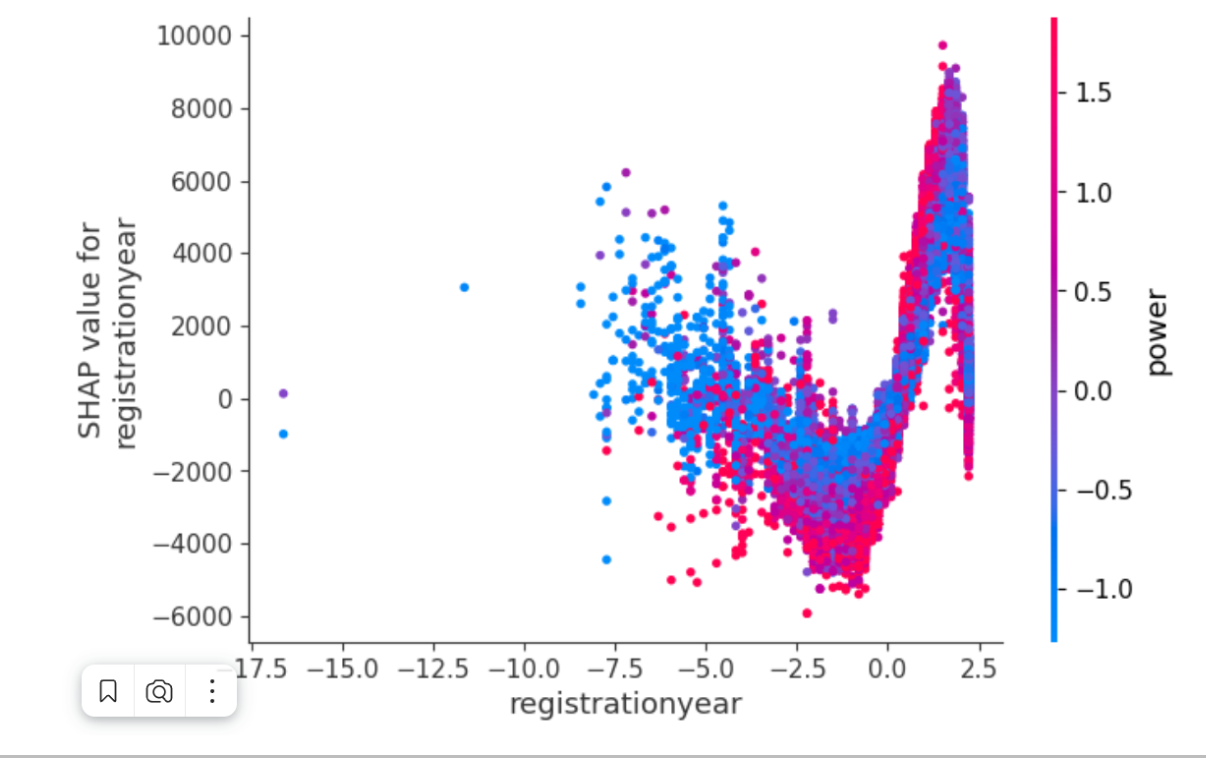

In [127]:
data = data[data['registrationyear'] > -10]

привет чистые данные

а теперь преступаем к обучению) но сначало посмотрим как распределены данные

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


Total number of outliers: 12691
Percentage of outliers:   4.37%


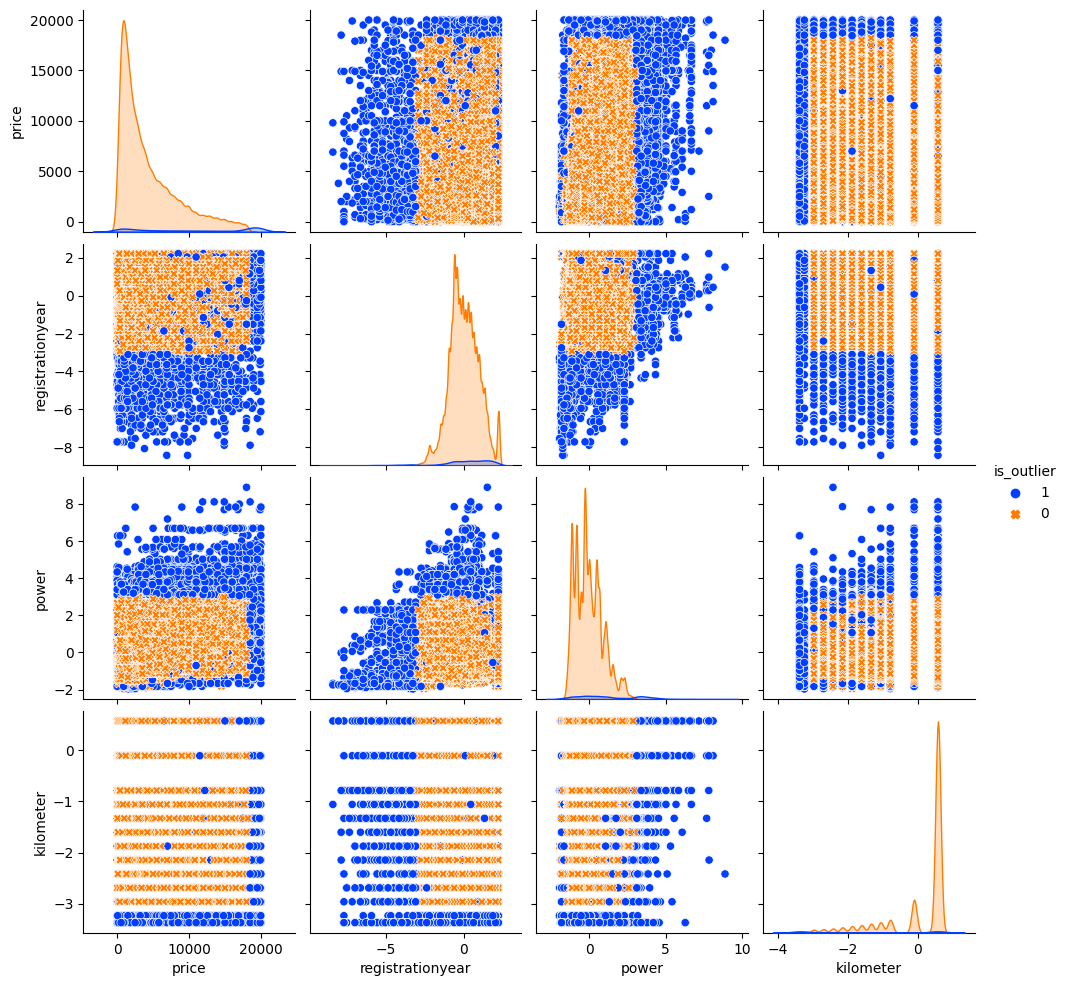

In [128]:
comparison_table, std_outliers = get_column_outliers(data[FTS_NU])
anomalies_report(std_outliers)
labeled_data = data[FTS_NU].copy()
labeled_data['is_outlier'] = std_outliers

sns.pairplot(data=labeled_data, vars = FTS_NU,
             hue='is_outlier', hue_order=[1, 0],
             markers=['X', 'o'],  palette='bright');

согласитесь выглядит куда лучше) особо и выбивающихся нет

In [129]:
data.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [130]:
X = ['vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired']
y = ['price']

train + valid = trava

## Обучение catboost

In [131]:
train_data = Pool(data=train[X],
                  label=train[y],
                 )
tra_va_data = Pool(data=tra_va[X],
                  label=tra_va[y],
                 )

In [132]:
params = {'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
              'learning_rate': 0.7,
              'random_seed': 2007,
              'verbose':100}

In [133]:
cv_data = cv(
    params = params,
    pool = tra_va_data,
    iterations = 2000,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=100,
    plot="True"
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1555.794933
bestIteration = 969

Training on fold [1/5]

bestTest = 1582.308482
bestIteration = 1350

Training on fold [2/5]

bestTest = 1569.159163
bestIteration = 1164

Training on fold [3/5]

bestTest = 1593.413422
bestIteration = 978

Training on fold [4/5]

bestTest = 1573.916005
bestIteration = 1026



In [134]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]

iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  \
1350        1350     1575.661277      13.991819      1334.103033   

      train-RMSE-std  
1350       10.873747

1560 , довольно много , но меньше чем просили в задание

давайте изучим как модель принимает решение , может найдём что-нибудь интересное . Для этого обучим модель на всех tra_va данных и посмотрим как она заполяет их. про тестовую выборку забываем до последнего пункта

In [135]:
params = {'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
              'learning_rate': 0.7,
              'random_seed': 2007,
              'iterations' : 1200,
              'verbose':100}

In [136]:
model_cat = CatBoostRegressor(**params)

In [137]:
%%time
model_cat.fit(tra_va_data)

0:	learn: 2828.2410513	total: 16.1ms	remaining: 19.3s
100:	learn: 1608.7254777	total: 1.79s	remaining: 19.5s
200:	learn: 1532.6357097	total: 3.7s	remaining: 18.4s
300:	learn: 1488.9440322	total: 5.48s	remaining: 16.4s
400:	learn: 1460.5407070	total: 7.01s	remaining: 14s
500:	learn: 1439.6847215	total: 8.51s	remaining: 11.9s
600:	learn: 1420.7198722	total: 10s	remaining: 9.99s
700:	learn: 1403.3643069	total: 11.4s	remaining: 8.14s
800:	learn: 1390.4837354	total: 12.9s	remaining: 6.43s
900:	learn: 1378.0912757	total: 14.3s	remaining: 4.75s
1000:	learn: 1366.8779327	total: 15.8s	remaining: 3.14s
1100:	learn: 1357.1970065	total: 17.2s	remaining: 1.55s
1199:	learn: 1348.7482092	total: 18.7s	remaining: 0us
CPU times: total: 2min 40s
Wall time: 19 s


## Анализ catboost

ошибка сопостовима с тестом те модель не переучена
<br>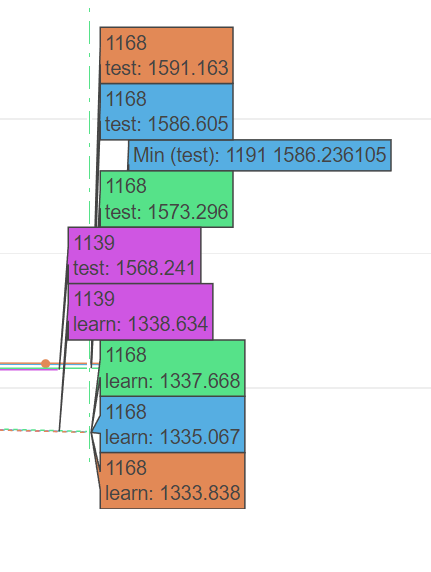

In [138]:
!pip install shap

In [139]:
shap.initjs()

In [140]:
tra_va = tra_va.reset_index(drop = True)

In [141]:
%%time
tra_va['y_pred'] = model_cat.predict(tra_va[X])

CPU times: total: 391 ms
Wall time: 74 ms


по времени всё очень хорошо обучение 2минуты + 0.4c на предикт 200к+ данных

In [142]:
tra_va_an = tra_va[['price','y_pred']]
tra_va_an['difference'] = np.sqrt((tra_va_an['price'] - tra_va_an['y_pred'])**2)
tra_va_an.sort_values(by = 'difference',ascending = False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


price        y_pred    difference
15810       1  16727.802446  16726.802446
88811   19500   2885.800824  16614.199176
43254   19500   3414.743420  16085.256580
40261     305  16355.818735  16050.818735
25868   17900   2290.029214  15609.970786
...       ...           ...           ...
52903    1290   1290.039990      0.039990
181548  11890  11890.038902      0.038902
89783    1500   1499.963320      0.036680
98052    4990   4989.969821      0.030179
104831   3500   3500.026964      0.026964

[232584 rows x 3 columns]

In [143]:
tra_va_an['difference'].median()

555.5174667588606

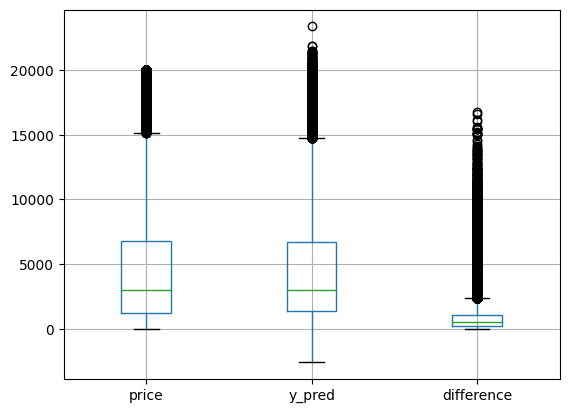

In [144]:
tra_va_an.boxplot()
plt.show()

оно делает -предикт ...... + в целом разница более меннее адекватная , как мы видем в основном модель справляется хорошо , но есть исключительные значения где разница в предикте и реальнолсти бешеная 10 rmse заключается в 1 примере

In [145]:
tra_va[tra_va['y_pred'] < 0]

price  vehicletype  registrationyear      gearbox  power        model  \
407       200  2379.357106              2016  4186.792682  107.0  3080.438627   
605       400  2379.357106              2016  4186.792682   50.0  1095.791749   
699       180  2379.357106              2000  4186.792682  125.0  2657.482920   
979      1150  4911.211306              1998  4186.792682   75.0  2278.365935   
1656       10  2379.357106              1960  2541.829541   26.0  1906.143502   
...       ...          ...               ...          ...    ...          ...   
229686   1234  2379.357106              2004  2541.829541  102.0  6248.617904   
230297     20  2379.357106              1995  4186.792682   75.0   918.080797   
231334    100  6210.871868              1995  4186.792682  105.0  5176.491184   
231657    500  6210.871868              1997  4186.792682  107.0  5313.845070   
232093    149  2737.750146              1997  2541.829541  103.0  2646.295251   

        kilometer     fueltype        brand  repaired      y_pred  
407        150000  3798.504534  2202.429007         0 -180.986062  
605         30000  3798.504534  4207.709686         0 -125.235953  
699        150000  3798.504534  3287.303822         0  -63.261117  
979          5000  3798.504534  2202.429007         1  -28.849741  
1656         5000  2021.067116  1906.143502         1  -33.527925  
...           ...          ...          ...       ...         ...  
229686      10000  3798.504534  4661.740245         1 -341.454719  
230297      20000  3798.504534  2202.429007         1  -99.993653  
231334       5000  3798.504534  6541.014688         0 -172.758845  
231657     150000  3798.504534  4175.936442         0 -237.392902  
232093       5000  3798.504534  2851.407683         1 -958.604546  

[441 rows x 11 columns]

466 экземпляров с отрицательно предугаданной стоимостью ...

In [146]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(tra_va[X])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


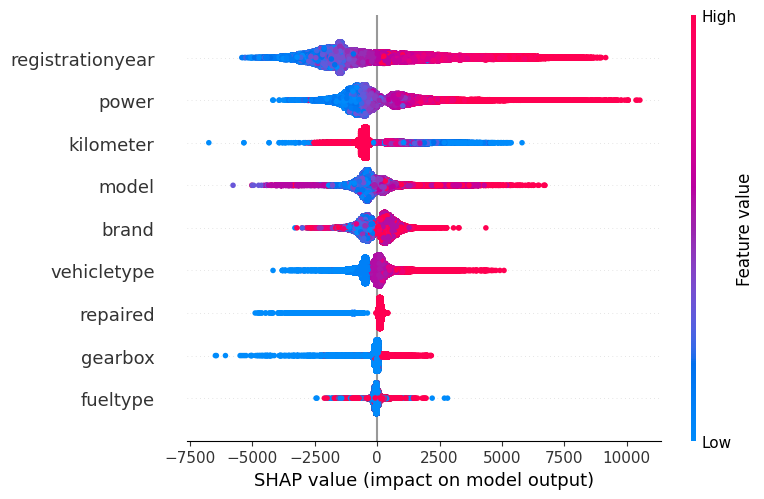

In [147]:
shap.summary_plot(shap_values, tra_va[X])

In [148]:
gr = model_cat.get_feature_importance(prettified=True)
gr

Feature Id  Importances
0  registrationyear    37.262421
1             power    17.837053
2             model    14.241786
3         kilometer    11.583737
4       vehicletype     8.257859
5             brand     6.004965
6           gearbox     1.972836
7          repaired     1.589566
8          fueltype     1.249778

неожиданный результат модель машины не на первом месте по важности , а на третьем

In [149]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [150]:
dummy_regr1 = DummyRegressor(strategy="mean")
dummy_regr1.fit(tra_va[X],tra_va[y])
dummy_regr1 = dummy_regr1.predict(tra_va[X])
sm_for_d = np.sqrt(mean_squared_error(dummy_regr1,tra_va[y]))
sm_for_d

4547.1302777441615

проверку на дурака модель прошла
<br>ну впринципе работает всё равно лучше чем просто среднее) давайте взгянем как система определяет и где ошибается в среднем

просто первый пример , отражает как в среднем модель принимает решение 

In [151]:
print('train_an')
print(tra_va_an.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[0,:], tra_va[X].iloc[0,:])

train_an
price         1000.000000
y_pred        1022.763146
difference      22.763146
Name: 0, dtype: float64


2 примера (в обе стороны)с бешенной разницей в предикте и реальности

In [152]:
print('train_an')
print(tra_va_an.iloc[89724,:])
shap.force_plot(explainer.expected_value, shap_values[89724,:], tra_va[X].iloc[89724,:])

train_an
price          800.000000
y_pred        2602.393368
difference    1802.393368
Name: 89724, dtype: float64


In [153]:
print('train_an')
print(tra_va_an.iloc[43252,:])
shap.force_plot(explainer.expected_value, shap_values[43252,:], tra_va[X].iloc[43252,:])

train_an
price         10500.000000
y_pred         4660.947028
difference     5839.052972
Name: 43252, dtype: float64


можем видеть что так происходит на критической стоимости авто + все параметры делают шаги не в ту стоимость . вывод стоит вернуться на стадию обработки . Но для проекта нужно больше ресурса чтобы это сделать

также пример хороших предиктов

In [154]:
print('train_an')
print(tra_va_an.iloc[188412,:])
shap.force_plot(explainer.expected_value, shap_values[188412,:], tra_va[X].iloc[188412,:])

train_an
price         625.000000
y_pred        555.072743
difference     69.927257
Name: 188412, dtype: float64


выводы , нужно подробнее рассмотреть года регистрации . Модель слишком сильно опирается на них. Проблемы с которыми сталкивается модель 1) мы не почистили price от выбросов , всё-таки стоило этим позаниматься) 2) слишком старые модели могут быть как супер дорогие так и супер дешёвые , думаю основные хвосты зарыты именно там

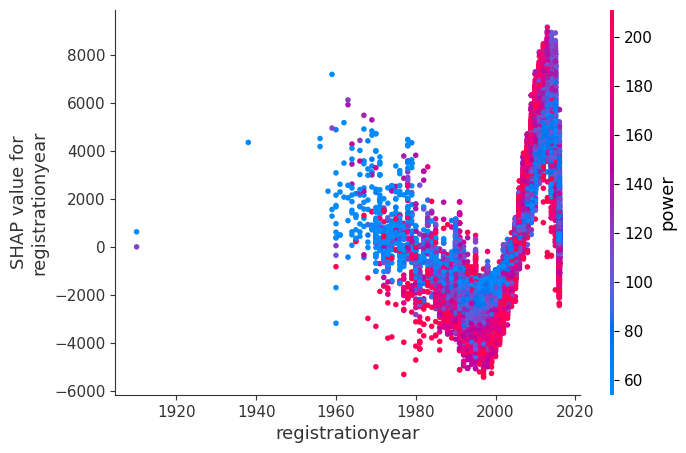

In [155]:
shap.dependence_plot("registrationyear", shap_values, tra_va[X])

как мне кажется основная собака зарыта в самых новых(+2) и самых старых машинах (-4), интересная ситуация , а что там с лошадками. 

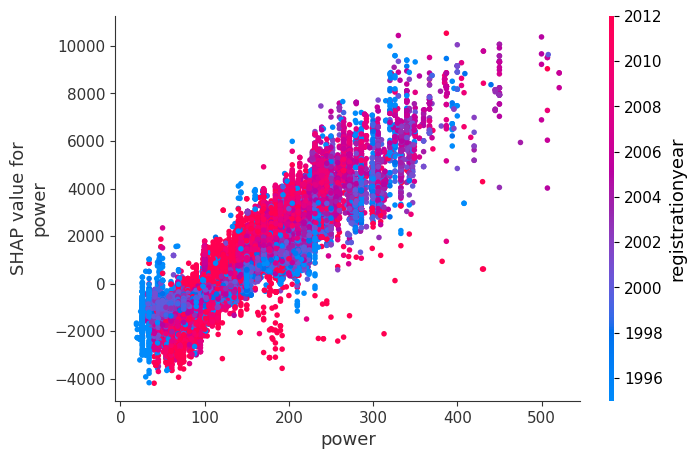

In [156]:
shap.dependence_plot("power", shap_values, tra_va[X])

о ну тут более менее линейная связь

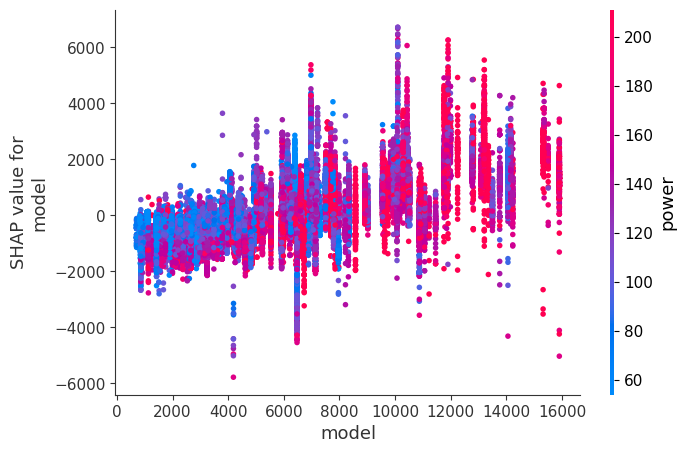

In [157]:
shap.dependence_plot("model", shap_values, tra_va[X])

ну теперь понятно почему важность фичи не такая высокая как я ожидал ... возможно стоило ещё поколдавать с типом инкодера , какая-то кореляция присутствует , но очень маленькая

такс ладно рассмотрели как работает cat , в общем выводе подведём итог

## обучение TweedieRegressor

меня в чате группы попросили посмотреть что в моих руках выдаст линейка. Вот сейчас и узнаем хочу pipeline который не нужен)) 

In [158]:
pipe = Pipeline([
    ("clf",linear_model.TweedieRegressor(power=0.1, alpha=0.5, link='log'))
    #("clf",linear_model.Ridge(alpha=.4))
    #("clf",linear_model.BayesianRidge())
])

In [159]:
%%time
pipe.fit(train[X],train[y])

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


CPU times: total: 4.55 s
Wall time: 472 ms


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Pipeline(steps=[('clf', TweedieRegressor(alpha=0.5, link='log', power=0.1))])

In [160]:
%%time
m0p = pipe.predict(valid[X])

CPU times: total: 0 ns
Wall time: 8 ms


In [161]:
from sklearn.metrics import mean_squared_error 

In [162]:
mean_squared_error = mean_squared_error(valid[y],m0p)

In [163]:
np.sqrt(mean_squared_error)

3271.161415584211

3200 на валидации , скука идём дальше , зато самое быстрое 

## обучение Keras

просто не сложная нейронка

In [164]:
earlystop_callb = EarlyStopping(monitor='val_mape',
                                patience=32,
                                )
checkpoint_callb = ModelCheckpoint(filepath='model_targ.h5',
                                   monitor='val_mape',
                                   save_best_only=True)

reducelr_callb = ReduceLROnPlateau(monitor = 'val_mape', 
                                   factor=0.1,
                                   patience=30,
                                   verbose=1)

In [165]:
inp1 = Input(shape=(9,))

x1 = Dense(36, activation='relu')(inp1)
x1 = Dense(72, activation='relu')(x1)
x1 = Dense(36, activation='relu')(x1)
#x1 = Dense(18, activation='relu')(x1)
x1 = Dense(1, activation='linear', name='targ')(x1)

model_one_targ0 = Model(inp1, x1)

model_one_targ0.compile(optimizer=Adam(0.01), loss='mse', metrics=['mape'])

model_one_targ0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 36)                360       
                                                                 
 dense_1 (Dense)             (None, 72)                2664      
                                                                 
 dense_2 (Dense)             (None, 36)                2628      
                                                                 
 targ (Dense)                (None, 1)                 37        
                                                                 
Total params: 5,689
Trainable params: 5,689
Non-trainable params: 0
_________________________________________________________________


оставлю оптимизатор адам на значение 0.01 не хочу ждать млрд лет , ровно также и с батч сайзом

In [166]:
%%time
history = model_one_targ0.fit(train[X], 
                              train[y], 
                              epochs=1000, 
                              batch_size=256, 
                              validation_data=(valid[X], valid[y]),
                              callbacks=[reducelr_callb,
                                         checkpoint_callb,
                                         earlystop_callb
                                         ]
                              )

Epoch 1/1000
727/727 [==============================] - 1s 1ms/step - loss: 11951340.0000 - mape: 1155.6097 - val_loss: 9124171.0000 - val_mape: 720.9980 - lr: 0.0100
Epoch 2/1000
727/727 [==============================] - 1s 1ms/step - loss: 8991231.0000 - mape: 1120.2798 - val_loss: 8680513.0000 - val_mape: 842.2106 - lr: 0.0100
Epoch 3/1000
727/727 [==============================] - 1s 1ms/step - loss: 8688427.0000 - mape: 1126.3223 - val_loss: 9751012.0000 - val_mape: 576.2506 - lr: 0.0100
Epoch 4/1000
727/727 [==============================] - 1s 1ms/step - loss: 8483886.0000 - mape: 1130.3788 - val_loss: 8166087.5000 - val_mape: 682.8168 - lr: 0.0100
Epoch 5/1000
727/727 [==============================] - 1s 1ms/step - loss: 8274781.5000 - mape: 1130.7814 - val_loss: 8039232.0000 - val_mape: 771.5229 - lr: 0.0100
Epoch 6/1000
727/727 [==============================] - 1s 1ms/step - loss: 8235969.0000 - mape: 1115.9255 - val_loss: 8746611.0000 - val_mape: 892.2991 - lr: 0.0100
Epo

<div class="alert alert-warning">
<b>Комментарий </b>

тест будем проводить над моделью из лучшей итерации (с такой же архитектурой)
</div>

In [167]:
try:
    model_one_targ0 = load_model('best/model_targ.h5')
except:
    print('проехали')

проехали


и всё у нас есть обученная сеть с весами , осталось только посмотреть скорость предикта

In [168]:
%%time
pred = np.array(model_one_targ0.predict(train[X]))
pred1 = np.array(model_one_targ0.predict(valid[X]))

1454/1454 [==============================] - 1s 540us/step
CPU times: total: 6.92 s
Wall time: 5.94 s


обучается сопостовимо с котиком , но скорость предикта медленная 

In [169]:
from sklearn.metrics import mean_squared_error

In [170]:
print(f"RMSE (train): {np.sqrt(mean_squared_error(train[y], pred))} ")
print(f"RMSE (val): {np.sqrt(mean_squared_error(valid[y], pred1))} ")

RMSE (train): 2694.4873351706365 
RMSE (val): 2702.8486633272964 


я уверен что можно выжить rmse меньше кота , но честно говоря не особо хочется этим заниматься уже) поэтому просто проанализируем проведём тест и сделаем выводы

также сделаем предикт на всей траве

In [171]:
tra_va

price  vehicletype  registrationyear      gearbox  power        model  \
0        1000  2379.357106              1999  4186.792682   75.0  2531.564195   
1          60  5046.400887              2002  2541.829541  150.0  5176.491184   
2        8700  5854.589611              2009  7130.525200  147.0  7137.282783   
3        1450  4911.211306              2001  4186.792682  120.0  2183.998786   
4        1900  2379.357106              1985  4186.792682   50.0  6395.772201   
...       ...          ...               ...          ...    ...          ...   
232579   3699  5046.400887              2001  4186.792682  131.0  6609.510748   
232580   9999  7024.528456              2004  4186.792682  163.0  5984.798501   
232581  12000  4911.211306              2007  7130.525200  163.0  5176.491184   
232582   4440  5046.400887              2002  7130.525200  170.0  5945.638735   
232583   2699  4911.211306              2001  4186.792682  116.0  5176.491184   

        kilometer     fueltype        brand  repaired        y_pred  
0          150000  3798.504534  2202.429007         1   1022.763146  
1            5000  3798.504534  6541.014688         1    522.374985  
2          150000  3798.504534  4949.138702         1   6390.690688  
3          150000  3798.504534  2202.429007         1   1455.908895  
4          100000  3798.504534  4661.740245         1   2196.973365  
...           ...          ...          ...       ...           ...  
232579     150000  6680.105285  6467.075847         1   3005.048671  
232580     125000  3798.504534  6467.075847         1   9477.281510  
232581     125000  6680.105285  6541.014688         1  11287.472090  
232582     150000  6680.105285  6157.915762         1   4094.375873  
232583     150000  3798.504534  6541.014688         1   2560.925042  

[232584 rows x 11 columns]

In [172]:
tra_va['y_pred'] = model_one_targ0.predict(tra_va[X])

7269/7269 [==============================] - 4s 531us/step


In [173]:
train_an = tra_va[['price','y_pred']]
train_an['difference'] = np.sqrt((train_an['price'] - train_an['y_pred'])**2)
train_an.sort_values(by = 'difference',ascending = False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


price        y_pred    difference
21351     140  19197.792969  19057.792969
29898   19000    584.801270  18415.198730
83897   19900   1753.174561  18146.825439
146573   1200  19083.328125  17883.328125
75540     397  18211.052734  17814.052734
...       ...           ...           ...
14502     900    900.102600      0.102600
157202    900    900.102600      0.102600
204219    900    900.102600      0.102600
157217    900    900.102600      0.102600
46139     900    900.102600      0.102600

[232584 rows x 3 columns]

In [174]:
train_an['difference'].median()

1175.69140625

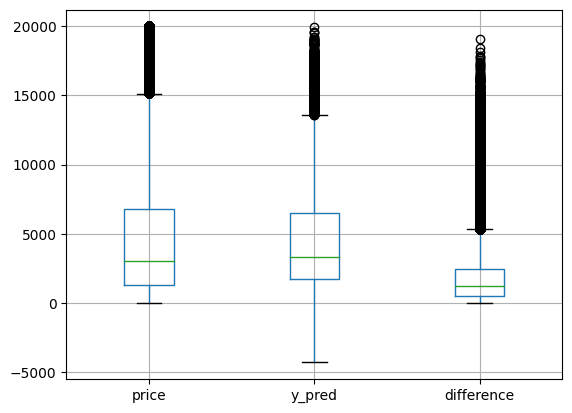

In [175]:
train_an.boxplot()
plt.show()

видно что модель слегка занижает в среднем

## анализ Keras

In [176]:
background = tra_va[X].values[np.random.choice(tra_va[X].shape[0], 1000, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model_one_targ0,background)
# compute shap values
shap_values = explainer.shap_values(background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


я попробовал сначало посмотреть на всём , но что-то как-то плохо получилось) мне стало лень ждать млрд лет , поэтому посмотрим на 1к точек

In [177]:
background = pd.DataFrame(background, columns=X)
shap_values = shap_values[0]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


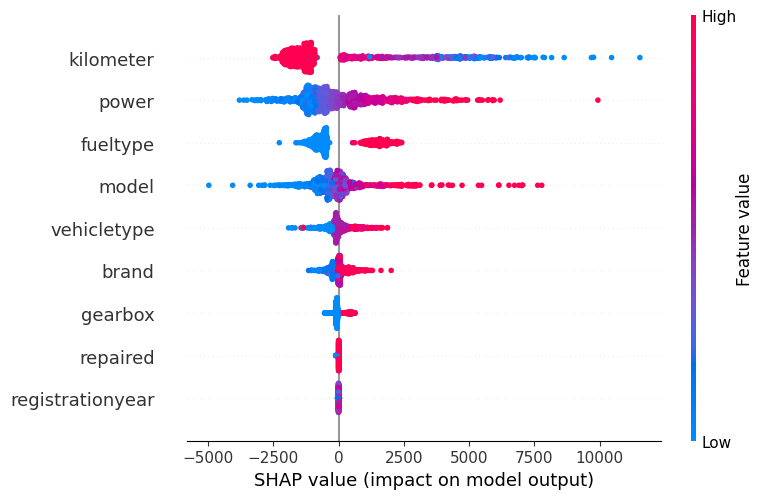

In [178]:
shap.summary_plot(shap_values, background)

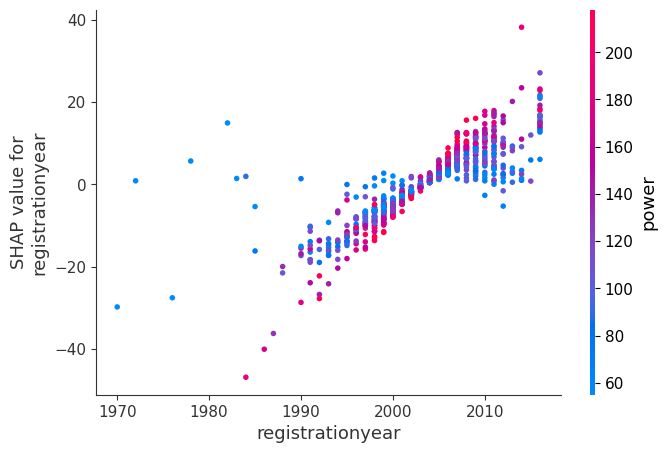

In [179]:
shap.dependence_plot('registrationyear', shap_values, background)

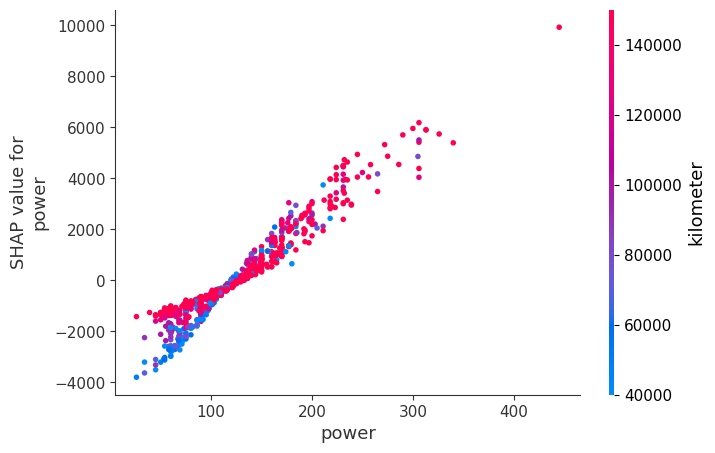

In [180]:
shap.dependence_plot('power', shap_values, background)

по двум верхним графикам ощущение складывается что нейронка смысл уловила , но всё равно слегка не то) нужно копаться и искать причину

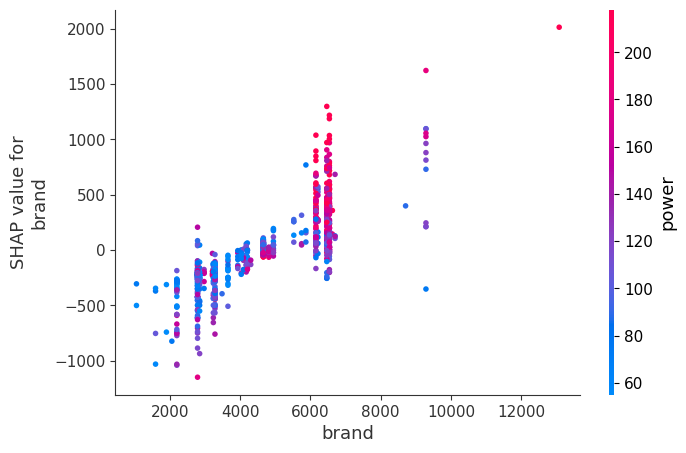

In [181]:
shap.dependence_plot('brand', shap_values, background)

ужас

In [182]:
feature_names = X


rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance['feature_importance_vals'] = shap_importance['feature_importance_vals']
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance

col_name  feature_importance_vals
5         kilometer              2051.565491
3             power              1187.357898
6          fueltype               982.965240
4             model               727.499531
0       vehicletype               311.825976
7             brand               236.832459
2           gearbox               147.542780
8          repaired                12.405226
1  registrationyear                 6.366598

первые две фичи по важности ровно такие же , но остальные отличаются в позиции важности

вывод как-будто модель имеет большую определённость , но её это не спасает 

## итоговый тест

In [183]:
answ = model_cat.predict(test[X])

In [184]:
end = np.sqrt(mean_squared_error(answ,test[y]))
end

1570.8739095156664

порог в 2500 прошёл

## общий вывод

<b>вывод:</b>
<br>основная информация с которой мы работали это столбец price (целевая переменная) , также задействовали все столбцы кроме временных + numberofpictures,postalcode
<br>итог эксперементов с моделями:на данный момент градиентный бустинг показался оптимальной моделью , очень быстрые предикты и адекватное время обучение (линейная регрессия не переходит через порог точности, но имеет более высокую скорость)
<br>рекомендации бизнесу: собрать базу данных с информацией про автомобили чтобы можно было эффективнее детектировать и работать с выбросами.Также поможет сделать более грамотный фичи инженеринг. 